In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import re
sns.set()

In [2]:
# pd.set_option('display.float', '{:.3f}'.format)
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [3]:
data_path = f"./data/loan_data_2007_2014.csv"
input_data = "train"

In [4]:
main_data = pd.read_csv(data_path)
data = main_data.copy() 

/tmp/ipykernel_13001/823853252.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  main_data = pd.read_csv(data_path)


In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,466285.0,2.331420e+05,1.346050e+05,0.00,1.165710e+05,2.331420e+05,3.497130e+05,4.662840e+05
id,466285.0,1.307973e+07,1.089371e+07,54734.00,3.639987e+06,1.010790e+07,2.073121e+07,3.809811e+07
member_id,466285.0,1.459766e+07,1.168237e+07,70473.00,4.379705e+06,1.194108e+07,2.300154e+07,4.086083e+07
loan_amnt,466285.0,1.431728e+04,8.286509e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt,466285.0,1.429180e+04,8.274371e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt_inv,466285.0,1.422233e+04,8.297638e+03,0.00,8.000000e+03,1.200000e+04,1.995000e+04,3.500000e+04
int_rate,466285.0,1.382924e+01,4.357587e+00,5.42,1.099000e+01,1.366000e+01,1.649000e+01,2.606000e+01
installment,466285.0,4.320612e+02,2.434855e+02,15.67,2.566900e+02,3.798900e+02,5.665800e+02,1.409990e+03
annual_inc,466281.0,7.327738e+04,5.496357e+04,1896.00,4.500000e+04,6.300000e+04,8.896000e+04,7.500000e+06
dti,466285.0,1.721876e+01,7.851121e+00,0.00,1.136000e+01,1.687000e+01,2.278000e+01,3.999000e+01


In [6]:
data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [8]:
data.dtypes.value_counts()

float64    46
object     22
int64       7
Name: count, dtype: int64

In [9]:
data.select_dtypes(include="object").columns.values

array(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d',
       'application_type'], dtype=object)

First lets confirm that our contunous varibles are numeric. Lets get rid of stirngs and alphanumeircs. Strip the number

In [10]:
data.grade.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [11]:
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [12]:
def transform_term(val): return np.float32(re.search(r'\d+', str(val)).group()) if re.search(r'\d+', str(val)) else np.float32(0)

In [13]:
data["term"] = data["term"].apply(transform_term)

In [14]:
print(type(data.term[0]))
data.term.unique()

<class 'numpy.float32'>


array([36., 60.], dtype=float32)

In [15]:
data.emp_length.unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [16]:
def transform_empl_length(val):
    return np.float64(re.search(r'\d+', str(val)).group()) if re.search(r'\d+', str(val)) else np.float64(0)

In [17]:
data["emp_length"] = data["emp_length"].apply(transform_empl_length)

In [18]:
print(type(data["emp_length"][0]))
data.emp_length.unique()

<class 'numpy.float64'>


array([10.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7.,  0.])

earliest_cr_line: The month the borrower's earliest reported credit line was opened. Here we will count the number of months past since the earliest credit line was issued.

In [19]:
data.earliest_cr_line

0         Jan-85
1         Apr-99
2         Nov-01
3         Feb-96
4         Jan-96
           ...  
466280    Apr-03
466281    Jun-97
466282    Dec-01
466283    Feb-03
466284    Feb-00
Name: earliest_cr_line, Length: 466285, dtype: object

In [20]:
data.earliest_cr_line.isna().sum()

29

In [21]:
def transform_date_by_month(val):
    if pd.isna(val):
        return pd.NA  # Return NaN if the input is NaN
    else:
        converted = pd.to_datetime(val, format="%b-%y")
        months_difference = (pd.to_datetime("2023-11-01") - converted) / pd.Timedelta(4, 'W')
        rounded_months = round(pd.to_numeric(months_difference))
        return rounded_months


In [22]:
data["earliest_cr_line_date"] = pd.to_datetime(data["earliest_cr_line"], format="%b-%y")

In [23]:

data["months_since_earliest_cr_line"] = round(pd.to_numeric((pd.to_datetime("2023-11-01") - data["earliest_cr_line_date"])/ pd.Timedelta(4, 'W')))
data["months_since_earliest_cr_line"].describe()

count    466256.000000
mean        337.510336
std         102.157195
min        -588.000000
25%         276.000000
50%         322.000000
75%         387.000000
max         715.000000
Name: months_since_earliest_cr_line, dtype: float64

We have detected the negative time since the earliest credit line date. Lets explore more.

In [24]:
data["earliest_cr_line_date"].isna().sum()

29

In [25]:
data.loc[:, ["earliest_cr_line", "earliest_cr_line_date", "months_since_earliest_cr_line"]][data["months_since_earliest_cr_line"] < 0]

,earliest_cr_line,earliest_cr_line_date,months_since_earliest_cr_line
1580,Sep-62,2062-09-01,-507.0
1770,Sep-68,2068-09-01,-585.0
2799,Sep-64,2064-09-01,-533.0
3282,Sep-67,2067-09-01,-572.0
3359,Feb-65,2065-02-01,-538.0
...,...,...,...
464003,Jan-68,2068-01-01,-576.0
464260,Jul-66,2066-07-01,-557.0
465100,Oct-67,2067-10-01,-573.0
465500,Sep-67,2067-09-01,-572.0


We can see that many rows have future time time such as Sep-62. These variables are incorreectly converted into Sept 2062 - becuase the origin of the built-in time scale starts after 1970. We colud solve this issue by preprocessing the data or impute with maximum values of this variable. I will choose later.

In [26]:
data.loc[data["months_since_earliest_cr_line"] < 0, "months_since_earliest_cr_line"] = data["months_since_earliest_cr_line"].max()
data["months_since_earliest_cr_line"].min()

157.0

Lets look at issued at date (issue_d).

In [27]:
data.issue_d

0         Dec-11
1         Dec-11
2         Dec-11
3         Dec-11
4         Dec-11
           ...  
466280    Jan-14
466281    Jan-14
466282    Jan-14
466283    Jan-14
466284    Jan-14
Name: issue_d, Length: 466285, dtype: object

In [28]:
data["issue_d_date"] = pd.to_datetime(data["issue_d"], format="%b-%y")
data["months_since_issued_date"] = round(pd.to_numeric((pd.to_datetime("2023-11-01") - data["issue_d_date"])/ pd.Timedelta(4, "W")))
print(type(data["months_since_issued_date"][0]))
data["months_since_issued_date"].describe()

<class 'numpy.float64'>


count    466285.000000
mean        132.860397
std          15.626526
min         116.000000
25%         122.000000
50%         128.000000
75%         139.000000
max         214.000000
Name: months_since_issued_date, dtype: float64

In [29]:
objLs = data.select_dtypes(include="object").columns.values
for col in objLs:
    print(f"{data[col].value_counts()}\n==========================================================")

grade
B    136929
C    125293
D     76888
A     74867
E     35757
F     13229
G      3322
Name: count, dtype: int64
sub_grade
B3    31686
B4    30505
C1    26953
C2    26740
B2    26610
C3    25317
B5    25252
C4    24105
B1    22876
C5    22178
A5    21757
D1    19261
A4    19045
D2    17046
D3    14916
D4    14099
A3    12568
D5    11566
A2    10956
A1    10541
E1     9033
E2     8669
E3     6976
E4     5992
E5     5087
F1     3940
F2     3001
F3     2708
F4     2067
F5     1513
G1     1109
G2      823
G3      583
G4      422
G5      385
Name: count, dtype: int64
emp_title
Teacher                              5399
Manager                              4438
Registered Nurse                     2316
RN                                   2204
Supervisor                           1967
                                     ... 
The Eastern Arizona AHEC                1
Delaware Quarries.com                   1
McCauley trucking and warehousing       1
save mart supermarkets                  

Lets explore discrete variables. I am going to use one-hot encoding for this exploration. The feature variable will increase by k-1 for each category in each variable. Variables such as:
- grade
- sub_grade
- home_ownership
- verification status 
- loan_status 
- purpose
- addr_state
- initial_list_status

In [30]:
one_hot_data = []
one_hot_variables = ["grade", "sub_grade", "home_ownership", "verification_status", "loan_status", "purpose", "addr_state", "initial_list_status"]

for category in one_hot_variables:
    one_hot_data.append(pd.get_dummies(data[category], prefix=category, prefix_sep=":"))

one_hot_data = pd.concat(one_hot_data, axis=1)
print(f"shape: {one_hot_data.shape}, type: {type(one_hot_data)}")

shape: (466285, 126), type: <class 'pandas.core.frame.DataFrame'>


concatenate with dataframe.

In [31]:
data =pd.concat([data, one_hot_data], axis=1)
print(f"new shape:{data.shape}")

new shape:(466285, 205)


Now, lets deal with missing values.

In [32]:
data.isnull().sum().sort_values(ascending=False)

open_il_6m                   466285
max_bal_bc                   466285
annual_inc_joint             466285
dti_joint                    466285
verification_status_joint    466285
                              ...  
sub_grade:C1                      0
sub_grade:C2                      0
sub_grade:C3                      0
sub_grade:C4                      0
initial_list_status:w             0
Length: 205, dtype: int64

lets find out the missing number and drop the varibale id it is missing more than 70% of data.

In [33]:
droppables = []
imputabels = []

for variable in data.columns.values:
    ratio = data[variable].isnull().sum() / data.shape[0]
    if ratio > 0.87: droppables.append(variable)
    if ratio > 0 and ratio < 0.87: imputabels.append(variable)

print(f"drops ({len(droppables)}): {droppables}\nimputables ({len(imputabels)}): {imputabels}")

drops (17): ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']
imputables (24): ['emp_title', 'annual_inc', 'desc', 'title', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'earliest_cr_line_date', 'months_since_earliest_cr_line']


In [34]:
print(f"Before dropping cols: {data.shape}")
data.drop(columns=droppables, inplace=True)
print(f"After dropping cols: {data.shape}")

Before dropping cols: (466285, 205)
After dropping cols: (466285, 188)


Total revolving high credit limit / credit limit, Failry, the missing values are equal to funded_amnt. Similarly, we have only 4 missing entries in annual_inc variable. It would be reasonable to fill with mean values,

In [35]:
data['total_rev_hi_lim'].fillna(data['funded_amnt'], inplace=True)

In [36]:
data["annual_inc"].describe()

count    4.662810e+05
mean     7.327738e+04
std      5.496357e+04
min      1.896000e+03
25%      4.500000e+04
50%      6.300000e+04
75%      8.896000e+04
max      7.500000e+06
Name: annual_inc, dtype: float64

In [37]:
data["annual_inc"].fillna(data["annual_inc"].mean(), inplace=True)

In [38]:
# picked numeric faetures 
cols_to_impute_with_zeros = ["months_since_earliest_cr_line", "mths_since_last_record", "acc_now_delinq", "total_acc", "pub_rec", "open_acc", "inq_last_6mths", "delinq_2yrs", "emp_length"]
for col in cols_to_impute_with_zeros:
    data[col].fillna(0, inplace=True)

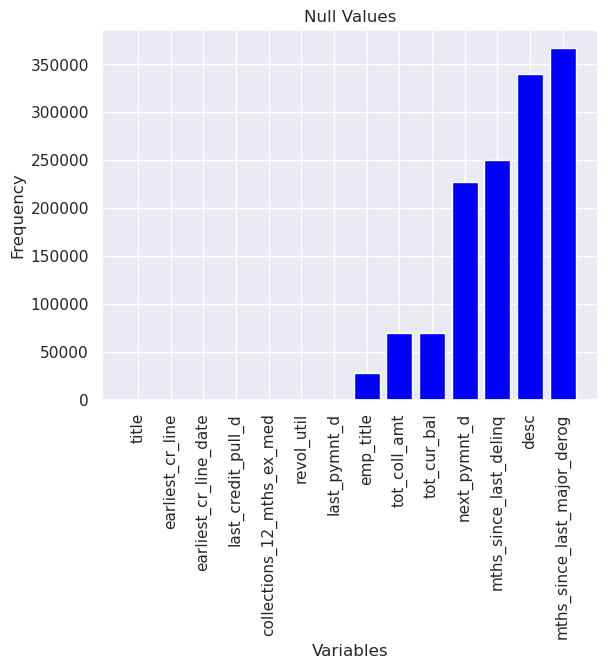

In [39]:
null_data = data.isnull().sum()
null_data = null_data.loc[null_data > 0].sort_values()

plt.bar(null_data.index, null_data,  color="blue")
plt.title("Null Values")
plt.xlabel("Variables")
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.show()


Data Preparation

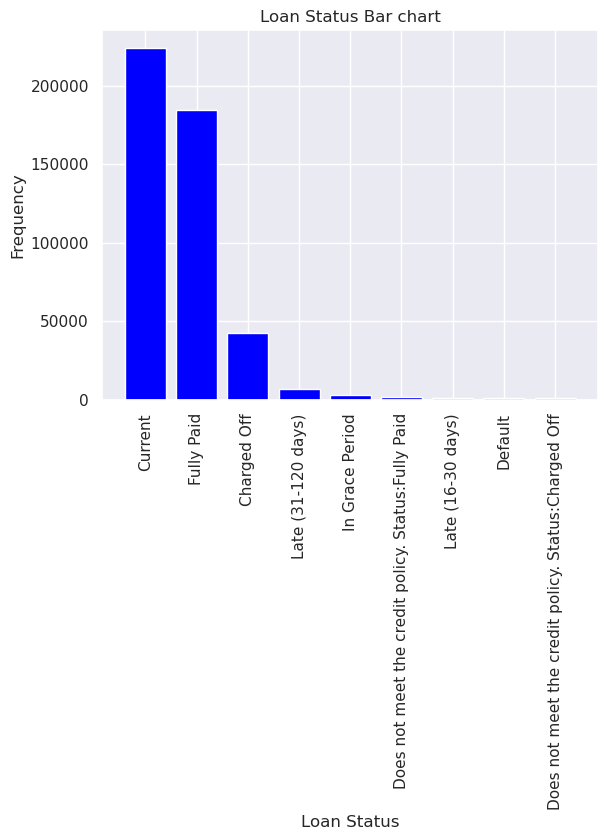

In [40]:
plt.bar(data["loan_status"].value_counts().index, data["loan_status"].value_counts(),  color="blue")
plt.title("Loan Status Bar chart")
plt.xlabel("Loan Status")
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.show()


Lets create a target variable. Here, I will create a good loan vs bad loan variable (good_bad). 1- Good (non-defaulters), 0 - Bad (defaulters)

In [41]:
defaulter_label = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "Late (31-120 days)"]

data["good_bad"] = np.where(data["loan_status"].isin(defaulter_label), 0, 1)

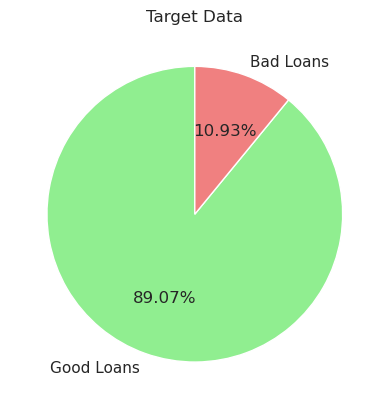

In [42]:
label_mapping = {0: 'Bad Loans', 1: 'Good Loans'}
temp_loan_data = data["good_bad"].map(label_mapping)

plt.pie(temp_loan_data.value_counts(), labels=temp_loan_data.value_counts().index,autopct='%2.2f%%', startangle=90, colors=['lightgreen', 'lightcoral'] )
plt.title("Target Data")
plt.show()

#### independent variables 

How will we categorise continious variables into categorical varibales. Binining, but how do we define the range ? Fine classing.

##### Fine Classing 
Fine classing, also known as fine binning, is a data preprocessing technique used in statistical analysis and machine learning to group continuous or numerical data into a larger number of smaller, more specific intervals or bins. This process is an extension of the binning or discretization process, which involves dividing a continuous variable into intervals or bins.

Fine classing aims to capture more detailed patterns and variations in the data by creating smaller intervals. This can be particularly useful when working with datasets that have a wide range or exhibit non-linear relationships.

The process of fine classing involves the following steps:

- Determine Number of Bins: Unlike coarse binning, where a smaller number of bins are used for a broader overview, fine classing involves choosing a larger number of bins to create more detailed intervals.

- Define Bin Boundaries: Establish the boundaries of each bin, ensuring that they are well-distributed across the range of the variable. The choice of bin boundaries can affect the interpretability and performance of the model.

- Assign Data Points to Bins: Place each data point into its corresponding bin based on the defined boundaries. This step is crucial for subsequent analysis or modeling.

Fine classing is often applied in various domains, including finance, marketing, and healthcare. In finance, for example, it might be used to create fine classes for credit score ranges to better assess the risk associated with different credit profiles. In marketing, it could be applied to customer age or income data for targeted campaign strategies. In healthcare, fine classing might be used to analyze patient data for personalized treatment plans.

The choice between fine classing and other binning techniques depends on the specific characteristics of the dataset and the goals of the analysis or modeling task. Fine classing may provide more detailed insights but may also lead to overfitting or increased computational complexity in certain situations. As with any preprocessing technique, it is important to carefully consider its implications for the downstream analysis or modeling.


Here, we are dealing with the categorical variables. we need to know the ability of each categories to predict the correct outcome. 

##### Weight of evidence 

Weight of Evidence (WoE) was developed primarily for the credit and financial industries to help build more predictive models to evaluate the risk of loan default. That is, to predict how likely the money lent to a person or institution is to be lost. Thus, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default).

- WoE will be 0 if the $P(Goods) / P(Bads) = 1$, that is, if the outcome is random for that group.
- If $P(Bads) > P(Goods)$ the odds ratio will be $< 1$ and,
- WoE will be $< 0$ if, $P(Goods) > P(Bads).$
  
WoE is well suited for Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., 


$WoE_i$ : $ln(P(Goods)/P(Bads))$. The WoE are better far from zero. 


Suppose we have K categories, and we have computed WoE for each of the categories. 

##### Information value: 

Information Value (IV) is a measure commonly used in credit scoring and binary classification problems to assess the predictive power of an independent variable (feature) with respect to the target variable. It is particularly popular in the context of credit risk modeling.

\begin{equation}
    \sum_{i=1}^{k} (\%good - \% bad) \cdot \ln\left(\frac{\%good}{\%bad}\right)
\end{equation}

The Information Value provides a single, consolidated measure of the discriminatory power of the variable. Higher Information Values indicate stronger predictive power. Here's how Information Value is typically interpreted:

- $IV < 0.02 $ : No predictive power
- $0.02 < IV < 0.1 $ :  Weak predictive power
- $0.1 < IV < 0.3 $ : Medium predictive power
- $0.3 < IV < 0.5 $ :  Strong predictive power
- $IV > 0.5 $ :  Suspisciously high


- IV is based on the concept of entropy: It measures the reduction in entropy (uncertainty) about the target variable achieved by dividing the data into different categories based on the independent variable.

- It helps in feature selection: Variables with low or zero Information Value may be candidates for removal from the model, as they contribute little to the predictive power.

- Monotonicity: In practice, it's often desirable for the Information Value to exhibit a monotonic relationship with the predictive power. This means that as you move through the categories of a variable, the Information Value should generally increase or decrease.

*There are more advanced methods to use, as it uses WoE which leads to overfitting*


#### Data Split

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(['good_bad'], axis=1), data["good_bad"], test_size=0.2, random_state=45)
print(f"X tains shape: {x_train.shape},Y train shape: {y_train.shape}, test shape: {x_test.shape}, Y test shape: {y_test.shape}")

X tains shape: (373028, 188),Y train shape: (373028,), test shape: (93257, 188), Y test shape: (93257,)


In [45]:
if input_data == "train":
    x_train_prep = x_train.copy()
    y_train_prep = y_train.copy()
else:
    x_train_prep = x_test.copy()
    y_train_prep = y_test.copy()

In [46]:
df_grade = pd.concat([x_train_prep['grade'], y_train_prep], axis=1)
df_grade.head()

,grade,good_bad
210472,F,0
334018,D,1
375753,D,1
6262,G,0
85721,B,0


##### WoE of Grade

In [47]:
df_grade.groupby(df_grade.columns.values[0], as_index=False)[df_grade.columns.values[1]].count()

,grade,good_bad
0,A,60052
1,B,109517
2,C,100085
3,D,61531
4,E,28583
5,F,10628
6,G,2632


In [48]:
df_grade.groupby(df_grade.columns.values[0], as_index=False)[df_grade.columns.values[1]].mean()

,grade,good_bad
0,A,0.960767
1,B,0.921300
2,C,0.885387
3,D,0.847199
4,E,0.804744
5,F,0.757998
6,G,0.721505


In [49]:
df_grade = pd.concat([df_grade.groupby(df_grade.columns.values[0], as_index=False)[df_grade.columns.values[1]].count(),
                      df_grade.groupby(df_grade.columns.values[0], as_index=False)[df_grade.columns.values[1]].mean()], axis=1)

df_grade

,grade,good_bad,grade,good_bad
0,A,60052,A,0.960767
1,B,109517,B,0.921300
2,C,100085,C,0.885387
3,D,61531,D,0.847199
4,E,28583,E,0.804744
5,F,10628,F,0.757998
6,G,2632,G,0.721505


In [50]:
df_grade = df_grade.iloc[:, [0,1,3]]
df_grade.columns = [df_grade.columns.values[0], "n_observation", "prop_good"]
df_grade

,grade,n_observation,prop_good
0,A,60052,0.960767
1,B,109517,0.921300
2,C,100085,0.885387
3,D,61531,0.847199
4,E,28583,0.804744
5,F,10628,0.757998
6,G,2632,0.721505


In [51]:
df_grade["prop_n_observation"] = df_grade["n_observation"]/df_grade["n_observation"].sum()
df_grade

,grade,n_observation,prop_good,prop_n_observation
0,A,60052,0.960767,0.160985
1,B,109517,0.921300,0.293589
2,C,100085,0.885387,0.268304
3,D,61531,0.847199,0.164950
4,E,28583,0.804744,0.076624
5,F,10628,0.757998,0.028491
6,G,2632,0.721505,0.007056


In [52]:
# count the number fof good borrowers and bad borrwers from each category 
df_grade["n_good"] = df_grade["prop_good"] * df_grade["n_observation"]
df_grade["n_bad"] = (1 - df_grade["prop_good"]) * df_grade["n_observation"]

# proportion of good and bad loans in each category 
df_grade["prop_n_good"] = df_grade["n_good"] / df_grade["n_good"].sum()
df_grade["prop_n_bad"] = df_grade["n_bad"] / df_grade["n_bad"].sum()

df_grade

,grade,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad
0,A,60052,0.960767,0.160985,57696.0,2356.0,0.173629,0.057839
1,B,109517,0.921300,0.293589,100898.0,8619.0,0.303641,0.211592
2,C,100085,0.885387,0.268304,88614.0,11471.0,0.266673,0.281608
3,D,61531,0.847199,0.164950,52129.0,9402.0,0.156876,0.230815
4,E,28583,0.804744,0.076624,23002.0,5581.0,0.069222,0.137011
5,F,10628,0.757998,0.028491,8056.0,2572.0,0.024244,0.063141
6,G,2632,0.721505,0.007056,1899.0,733.0,0.005715,0.017995


In [53]:
df_grade['woe'] = np.log(df_grade["prop_n_good"]/df_grade["prop_n_bad"])
df_grade = df_grade.sort_values(["woe"])
df_grade.reset_index(drop=True)
df_grade

,grade,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe
6,G,2632,0.721505,0.007056,1899.0,733.0,0.005715,0.017995,-1.147020
5,F,10628,0.757998,0.028491,8056.0,2572.0,0.024244,0.063141,-0.957224
4,E,28583,0.804744,0.076624,23002.0,5581.0,0.069222,0.137011,-0.682744
3,D,61531,0.847199,0.164950,52129.0,9402.0,0.156876,0.230815,-0.386158
2,C,100085,0.885387,0.268304,88614.0,11471.0,0.266673,0.281608,-0.054489
1,B,109517,0.921300,0.293589,100898.0,8619.0,0.303641,0.211592,0.361184
0,A,60052,0.960767,0.160985,57696.0,2356.0,0.173629,0.057839,1.099266


In [54]:
df_grade["diff_prop_good"] = df_grade["prop_good"].diff().abs()
df_grade["diff_woe"] = df_grade["woe"].diff().abs()
df_grade

,grade,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe
6,G,2632,0.721505,0.007056,1899.0,733.0,0.005715,0.017995,-1.147020,NaN,NaN
5,F,10628,0.757998,0.028491,8056.0,2572.0,0.024244,0.063141,-0.957224,0.036493,0.189796
4,E,28583,0.804744,0.076624,23002.0,5581.0,0.069222,0.137011,-0.682744,0.046746,0.274480
3,D,61531,0.847199,0.164950,52129.0,9402.0,0.156876,0.230815,-0.386158,0.042455,0.296586
2,C,100085,0.885387,0.268304,88614.0,11471.0,0.266673,0.281608,-0.054489,0.038188,0.331669
1,B,109517,0.921300,0.293589,100898.0,8619.0,0.303641,0.211592,0.361184,0.035912,0.415673
0,A,60052,0.960767,0.160985,57696.0,2356.0,0.173629,0.057839,1.099266,0.039467,0.738082


In [55]:
# lets calculate information value 
df_grade["IV"] = ((df_grade["prop_n_good"] - df_grade["prop_n_bad"]) * df_grade["woe"]).sum()
df_grade

,grade,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,IV
6,G,2632,0.721505,0.007056,1899.0,733.0,0.005715,0.017995,-1.147020,NaN,NaN,0.287499
5,F,10628,0.757998,0.028491,8056.0,2572.0,0.024244,0.063141,-0.957224,0.036493,0.189796,0.287499
4,E,28583,0.804744,0.076624,23002.0,5581.0,0.069222,0.137011,-0.682744,0.046746,0.274480,0.287499
3,D,61531,0.847199,0.164950,52129.0,9402.0,0.156876,0.230815,-0.386158,0.042455,0.296586,0.287499
2,C,100085,0.885387,0.268304,88614.0,11471.0,0.266673,0.281608,-0.054489,0.038188,0.331669,0.287499
1,B,109517,0.921300,0.293589,100898.0,8619.0,0.303641,0.211592,0.361184,0.035912,0.415673,0.287499
0,A,60052,0.960767,0.160985,57696.0,2356.0,0.173629,0.057839,1.099266,0.039467,0.738082,0.287499


Lets automate the process.

In [56]:
def compute_woe_iv(df, variable_name, target_df):
    copy_df = pd.concat([df[variable_name], target_df], axis=1)
    copy_df = pd.concat([copy_df.groupby(variable_name, as_index=False)[copy_df.columns.values[1]].count(),
                         copy_df.groupby(copy_df[variable_name], as_index=False)[copy_df.columns.values[1]].mean()
                         ], axis=1)
    
    copy_df = copy_df.iloc[:, [0,1,3]]
    copy_df.columns = [copy_df.columns.values[0], "n_observation", "prop_good"]
    copy_df["prop_n_observation"] = copy_df["n_observation"] / copy_df["n_observation"].sum()
    # it returns the proprtion of good loans from df
    copy_df["n_good"] = copy_df["prop_good"] * copy_df["n_observation"]
    copy_df["n_bad"] = (1- copy_df["prop_good"]) * copy_df["n_observation"]
    
    copy_df["prop_n_good"] = copy_df["n_good"] / copy_df["n_good"].sum()
    copy_df["prop_n_bad"] = copy_df["n_bad"] / copy_df["n_bad"].sum()
    
    copy_df["woe"] = np.log(copy_df["prop_n_good"] / copy_df["prop_n_bad"])
    copy_df["iv"] = ((copy_df["prop_n_good"] - copy_df["prop_n_bad"]) * copy_df["woe"]).sum()
    
    copy_df = copy_df.sort_values(["woe"])
    copy_df = copy_df.reset_index(drop=True)
    return copy_df

In [57]:
g_woe = compute_woe_iv(x_train_prep, "grade", y_train_prep)
g_woe

,grade,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,G,2632,0.721505,0.007056,1899.0,733.0,0.005715,0.017995,-1.147020,0.287499
1,F,10628,0.757998,0.028491,8056.0,2572.0,0.024244,0.063141,-0.957224,0.287499
2,E,28583,0.804744,0.076624,23002.0,5581.0,0.069222,0.137011,-0.682744,0.287499
3,D,61531,0.847199,0.164950,52129.0,9402.0,0.156876,0.230815,-0.386158,0.287499
4,C,100085,0.885387,0.268304,88614.0,11471.0,0.266673,0.281608,-0.054489,0.287499
5,B,109517,0.921300,0.293589,100898.0,8619.0,0.303641,0.211592,0.361184,0.287499
6,A,60052,0.960767,0.160985,57696.0,2356.0,0.173629,0.057839,1.099266,0.287499


In [58]:
def plot_woe(woe, x_tick_rotation=0):
    plt.figure(figsize=(15, 6))
    plt.plot(woe.iloc[:, 0].apply(str), woe['woe'], marker='o', linestyle='--', color='b', label=f'{woe.columns.values[0]} WoE Line chart')
    plt.xlabel(woe.columns.values[0])
    plt.xticks(rotation = x_tick_rotation)
    plt.ylabel("Weight of evidence")
    plt.title(f"Weight of evidence by {woe.columns.values[0]}")
    plt.legend()
    plt.show()

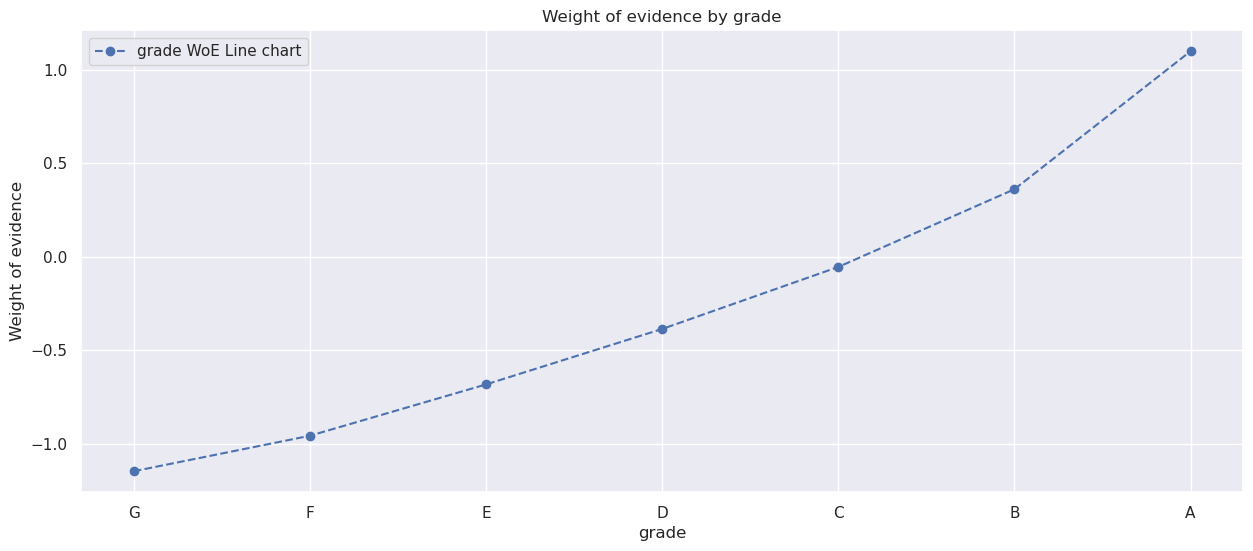

In [59]:
plot_woe(g_woe)

The grades have monotonically increase from G(worse) to A(best). The greater the grade better the weight of evidence.

In [60]:
list_of_ref_categories = []
list_of_dummy_variables = []
if input_data == "train":
    list_of_dummy_variables.extend([item for item in x_train_prep.columns.values if item.startswith('grade:')])
    list_of_ref_categories.append(list_of_dummy_variables[-1])
    print(f"{list_of_dummy_variables}\n{list_of_ref_categories}")

['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F', 'grade:G']
['grade:G']


In [61]:
home_ownership_woe = compute_woe_iv(x_train_prep, "home_ownership", y_train_prep)
home_ownership_woe

,home_ownership,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,OTHER,145,0.786207,0.000389,114.0,31.0,0.000343,0.000761,-0.796746,inf
1,NONE,40,0.800000,0.000107,32.0,8.0,0.000096,0.000196,-0.712663,inf
2,RENT,150878,0.873872,0.404468,131848.0,19030.0,0.396781,0.467177,-0.163324,inf
3,OWN,33279,0.891133,0.089213,29656.0,3623.0,0.089246,0.088943,0.003405,inf
4,MORTGAGE,188685,0.904380,0.505820,170643.0,18042.0,0.513530,0.442922,0.147914,inf
5,ANY,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf


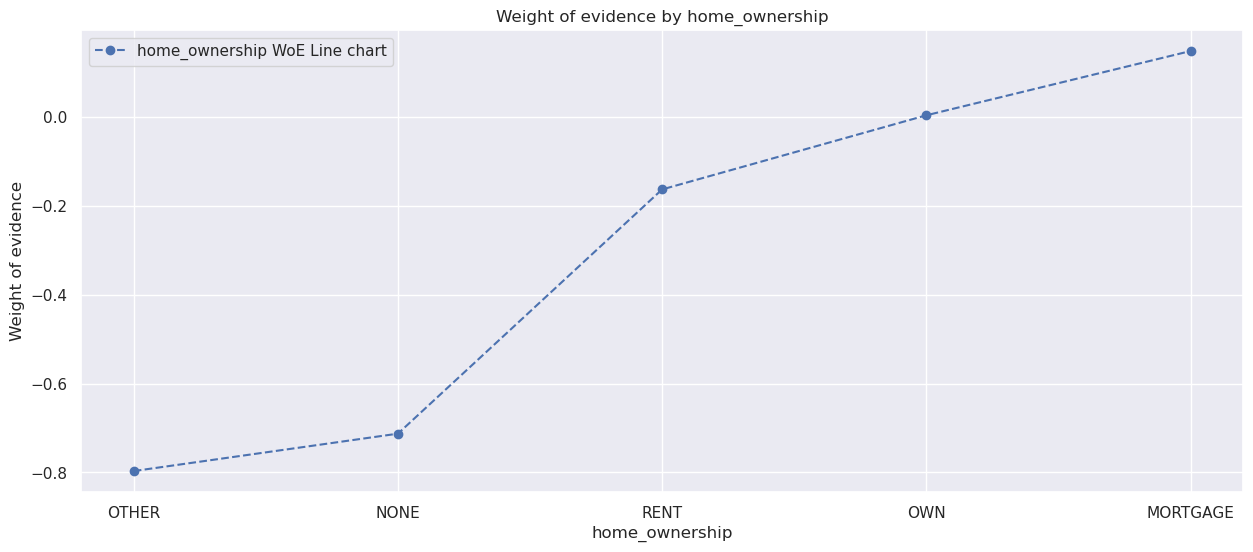

In [62]:
plot_woe(home_ownership_woe)

Lookin at the Chart, The categories other, and None are associated with highest probability of default. WoE tells us that these categories have very few loans (< 0.1% each), and only one observation with ANY home ownership status. It does not make sense to have dummy varibles, neither to loose data. Hence, we combine such under represented category of similar nature. we will cobmined those one with riskiest variable Rent. Final dummy varibles [Rent, OWN,Mortgage ]

In [63]:
x_train_prep["home_ownership:RENT_OTHER_NONE_ANY"] = sum([x_train_prep["home_ownership:RENT"], x_train_prep["home_ownership:NONE"], x_train_prep["home_ownership:OTHER"], x_train_prep["home_ownership:ANY"]])


In [64]:
if input_data == "train":
    list_of_dummy_variables.extend(["home_ownership:RENT_OTHER_NONE_ANY", "home_ownership:OWN", "home_ownership:MORTGAGE"])
    list_of_ref_categories.append("home_ownership:RENT_OTHER_NONE_ANY")
    print(f"{list_of_dummy_variables}\n{list_of_ref_categories}")

['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F', 'grade:G', 'home_ownership:RENT_OTHER_NONE_ANY', 'home_ownership:OWN', 'home_ownership:MORTGAGE']
['grade:G', 'home_ownership:RENT_OTHER_NONE_ANY']


In [65]:
addr_state_woe = compute_woe_iv(x_train_prep, "addr_state", y_train_prep)
addr_state_woe

,addr_state,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,NE,11,0.454545,0.000029,5.0,6.0,0.000015,0.000147,-2.281279,inf
1,IA,12,0.750000,0.000032,9.0,3.0,0.000027,0.000074,-1.000345,inf
2,ID,7,0.857143,0.000019,6.0,1.0,0.000018,0.000025,-0.307198,inf
3,NV,5225,0.862967,0.014007,4509.0,716.0,0.013569,0.017577,-0.258806,inf
4,AL,4685,0.873212,0.012559,4091.0,594.0,0.012311,0.014582,-0.169292,inf
5,FL,25231,0.874519,0.067638,22065.0,3166.0,0.066402,0.077724,-0.157433,inf
6,HI,1969,0.876587,0.005278,1726.0,243.0,0.005194,0.005966,-0.138457,inf
7,LA,4269,0.880300,0.011444,3758.0,511.0,0.011309,0.012545,-0.103684,inf
8,MO,5997,0.881941,0.016077,5289.0,708.0,0.015917,0.017381,-0.088017,inf
9,DE,1025,0.882927,0.002748,905.0,120.0,0.002723,0.002946,-0.078514,inf


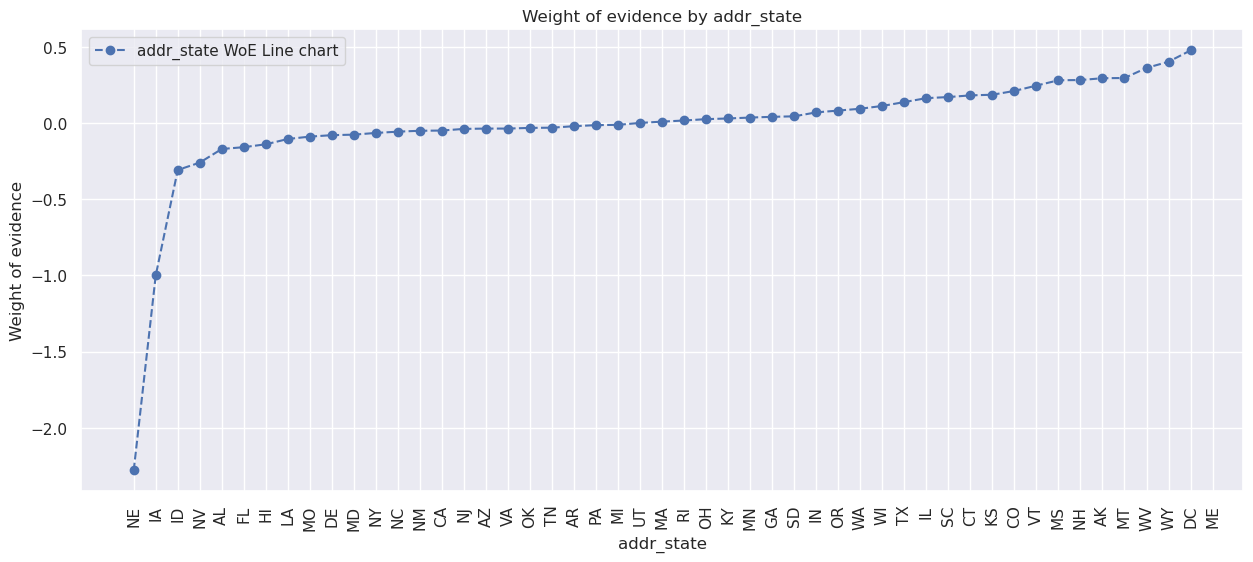

In [66]:
plot_woe(addr_state_woe, 90)

Looking at the graph, The NE, IA, and ID have very less observations, which has led them to have extreme WoE values. Lets cut them out and observe rest.

In [67]:
# we do not see the north dakota here. We want to add if that is true
if "addr_state:ND" not in x_train_prep.columns.values: x_train_prep['addr_state:ND'] = 0

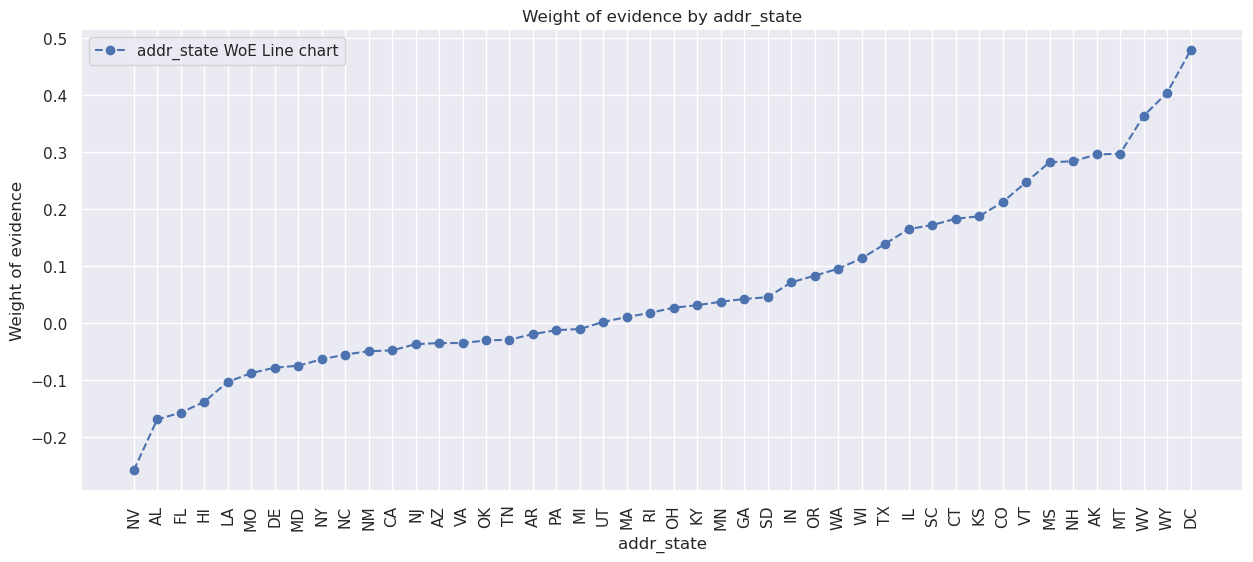

In [68]:
plot_woe(addr_state_woe.iloc[3:-1,:], 90)

By this chart, we can categorise multiple states into one such as NE, IA, NV, AL, ID, ND (as we have no information about) FL, HI into one as they have similar woe. Similarly, WV, WY, DC, and ME in another categoruy, and CO, VT, MS, NH, AK, MT in another and similar for other states. we can notice that NY, CA, TX havehigher number of observation, hence we will leave them as they are.

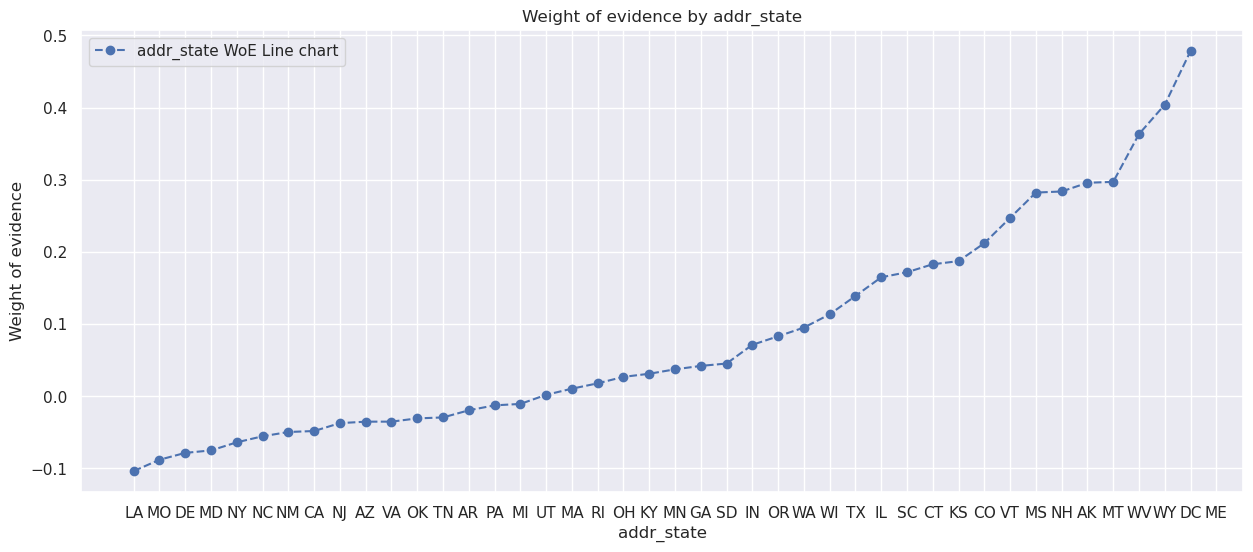

In [69]:
plot_woe(addr_state_woe.iloc[7:, :])

In [70]:
x_train_prep["addr_state:NE_IA_NV_AL_ID_ND_FL_HI"] = sum([x_train_prep['addr_state:ND'], x_train_prep['addr_state:NE'],
                                                         x_train_prep['addr_state:IA'], x_train_prep['addr_state:NV'],
                                                         x_train_prep['addr_state:FL'], x_train_prep['addr_state:HI'],
                                                         x_train_prep['addr_state:AL'], x_train_prep['addr_state:ID']])


x_train_prep["addr_state:LA_MO_DE_MD"] = sum([x_train_prep['addr_state:LA'], x_train_prep['addr_state:MO'], 
                                              x_train_prep['addr_state:DE'], x_train_prep['addr_state:MD']])

x_train_prep['addr_state:NC_NM'] = sum([x_train_prep['addr_state:NC'], x_train_prep['addr_state:NM']])


x_train_prep['addr_state:NJ_AZ_VA_OK_TN'] = sum([x_train_prep['addr_state:NJ'], x_train_prep['addr_state:AZ'],
                                              x_train_prep['addr_state:VA'], x_train_prep['addr_state:OK'],
                                              x_train_prep['addr_state:TN']])

x_train_prep['addr_state:AR_PR_MI'] = sum([x_train_prep['addr_state:AR'], x_train_prep['addr_state:PA'],
                                              x_train_prep['addr_state:MI']])


x_train_prep['addr_state:UT_MA_RI_OH'] = sum([x_train_prep['addr_state:UT'], x_train_prep['addr_state:MA'],
                                              x_train_prep['addr_state:RI'], x_train_prep['addr_state:OH']])


x_train_prep['addr_state:KY_MN_GA_SD'] = sum([x_train_prep['addr_state:KY'], x_train_prep['addr_state:MN'],
                                              x_train_prep['addr_state:GA'], x_train_prep['addr_state:SD']])



x_train_prep['addr_state:IN_OR_WA_WI'] = sum([x_train_prep['addr_state:IN'], x_train_prep['addr_state:WA'],
                                              x_train_prep['addr_state:OR'], x_train_prep['addr_state:WI'] ])

x_train_prep['addr_state:IL_SC_CT_KS_CO'] = sum([x_train_prep['addr_state:IL'], x_train_prep['addr_state:SC'],
                                                 x_train_prep['addr_state:CT'], x_train_prep['addr_state:KS'],
                                                 x_train_prep['addr_state:CO']])



x_train_prep['addr_state:VT_MS_NH_AK_MT'] = sum([x_train_prep['addr_state:VT'], x_train_prep['addr_state:MS'],
                                                    x_train_prep['addr_state:NH'], x_train_prep['addr_state:AK'],
                                                    x_train_prep['addr_state:MT']])

x_train_prep['addr_state:WV_WY_DC_ME'] = sum([x_train_prep['addr_state:WV'], x_train_prep['addr_state:WY'],
                                              x_train_prep['addr_state:DC'], x_train_prep['addr_state:ME'] ])


In [71]:
if input_data == "train":
    list_of_dummy_variables.extend(
        [   'addr_state:NY',
            'addr_state:CA',
            'addr_state:TX',
            'addr_state:NE_IA_NV_AL_ID_ND_FL_HI',
            'addr_state:LA_MO_DE_MD',
            'addr_state:NC_NM',
            'addr_state:NJ_AZ_VA_OK_TN',
            'addr_state:AR_PR_MI',
            'addr_state:UT_MA_RI_OH',
            'addr_state:KY_MN_GA_SD',
            'addr_state:IN_OR_WA_WI',
            'addr_state:IL_SC_CT_KS_CO',
            'addr_state:VT_MS_NH_AK_MT',
            'addr_state:WV_WY_DC_ME'
        ]
    )
    list_of_ref_categories.append('addr_state:NE_IA_NV_AL_ID_ND_FL_HI')

In [72]:
verification_status_woe = compute_woe_iv(x_train_prep, "verification_status", y_train_prep)
verification_status_woe

,verification_status,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,Verified,134320,0.872432,0.36008,117185.0,17135.0,0.352655,0.420656,-0.176326,0.021765
1,Source Verified,120074,0.895806,0.32189,107563.0,12511.0,0.323698,0.307139,0.052511,0.021765
2,Not Verified,118634,0.906536,0.31803,107546.0,11088.0,0.323647,0.272205,0.173098,0.021765


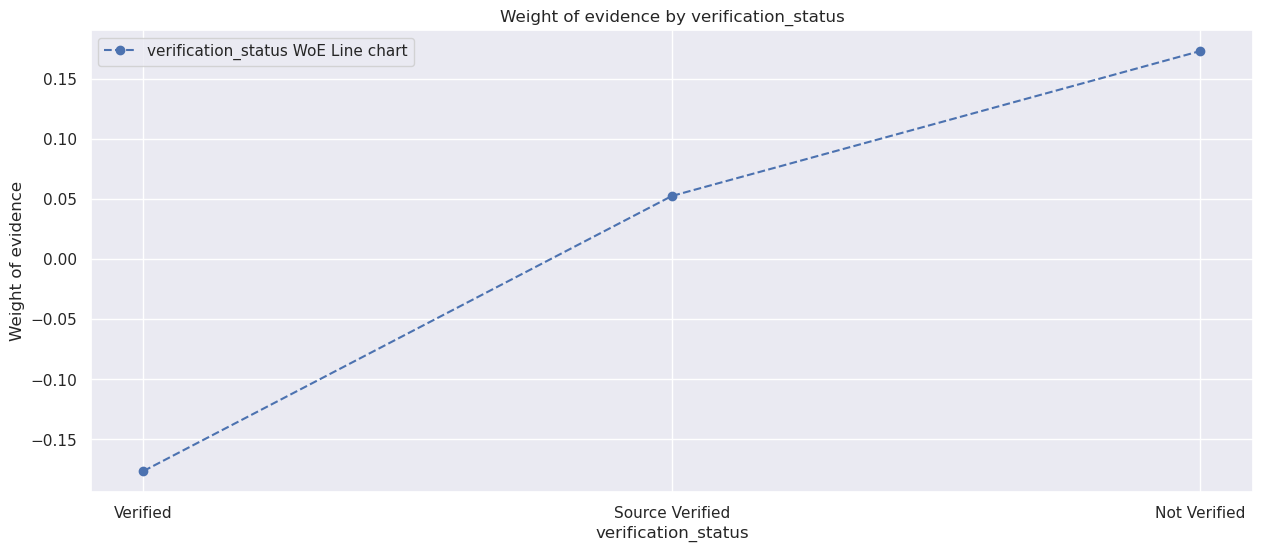

In [73]:
plot_woe(verification_status_woe)

In [74]:
if input_data == "train":
    list_of_dummy_variables.extend([item  for item in x_train_prep.columns.values if item.startswith("verification_status:")])
    list_of_ref_categories.append(list_of_dummy_variables[-1])

In [75]:
purpose_woe = compute_woe_iv(x_train_prep, "purpose", y_train_prep)
purpose_woe

,purpose,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,educational,326,0.782209,0.000874,255.0,71.0,0.000767,0.001743,-0.820373,0.03857
1,small_business,5651,0.785171,0.015149,4437.0,1214.0,0.013353,0.029803,-0.802899,0.03857
2,renewable_energy,276,0.836957,0.000740,231.0,45.0,0.000695,0.001105,-0.463202,0.03857
3,moving,2436,0.845649,0.006530,2060.0,376.0,0.006199,0.009231,-0.398085,0.03857
4,other,18931,0.860124,0.050750,16283.0,2648.0,0.049002,0.065007,-0.282640,0.03857
5,house,1843,0.862181,0.004941,1589.0,254.0,0.004782,0.006236,-0.265431,0.03857
6,medical,3673,0.867139,0.009846,3185.0,488.0,0.009585,0.011980,-0.223065,0.03857
7,vacation,1982,0.875378,0.005313,1735.0,247.0,0.005221,0.006064,-0.149583,0.03857
8,wedding,1887,0.877583,0.005059,1656.0,231.0,0.004984,0.005671,-0.129214,0.03857
9,debt_consolidation,219332,0.886793,0.587977,194502.0,24830.0,0.585331,0.609564,-0.040567,0.03857


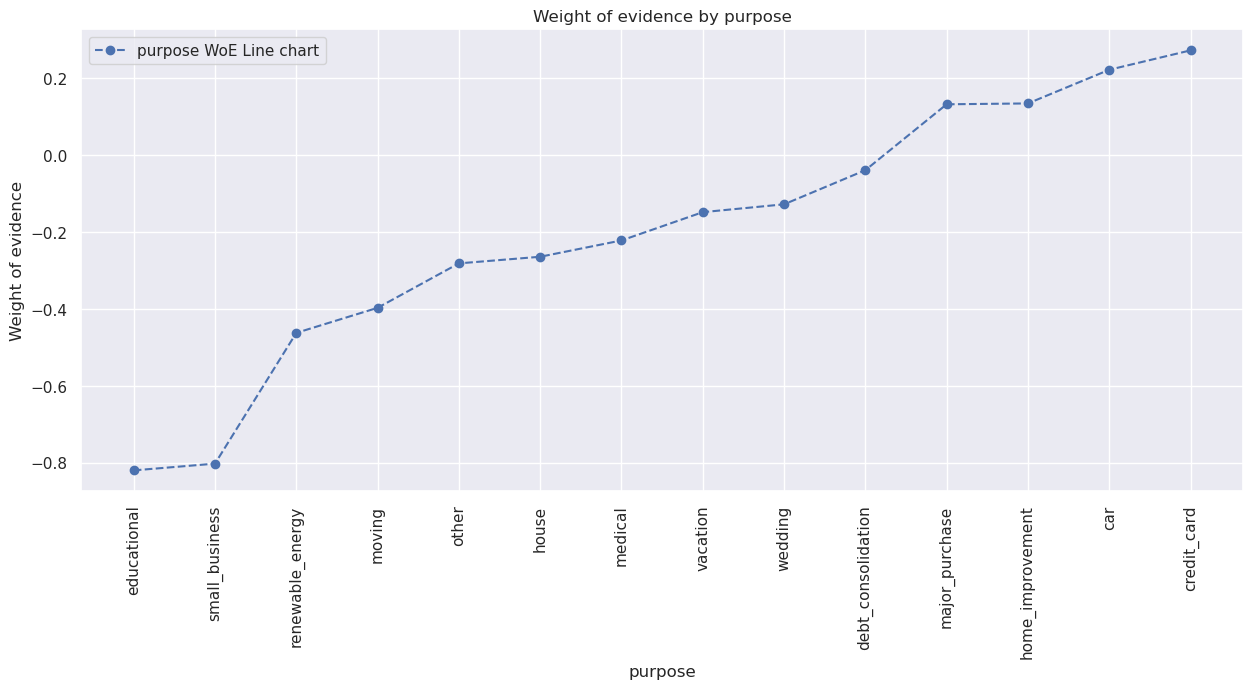

In [76]:
plot_woe(purpose_woe, 90)

In [77]:
x_train_prep['purpose:educ_small_biz_wedd_renno_enerby_moving_other_house'] = sum([x_train_prep['purpose:educational'], x_train_prep['purpose:small_business'],
                                                                 x_train_prep['purpose:wedding'], x_train_prep['purpose:renewable_energy'],
                                                                 x_train_prep['purpose:moving'], x_train_prep['purpose:house'],
                                                                  x_train_prep['purpose:other']])
x_train_prep["purpose:medical_vacation_wedding"] = sum([x_train_prep["purpose:medical"], x_train_prep["purpose:vacation"], x_train_prep["purpose:wedding"]])

x_train_prep["purpose:major_purchase_home_imp_car"]  = sum([x_train_prep["purpose:major_purchase"], x_train_prep["purpose:home_improvement"],
                                                            x_train_prep["purpose:car"]])

In [78]:
if input_data == "train":
    list_of_dummy_variables.extend(["purpose:educ_small_biz_wedd_renno_enerby_moving_other_house","purpose:medical_vacation_wedding", 
                                    "purpose:major_purchase_home_imp_car", "purpose:credit_card", "purpose:debt_consolidation"])
    list_of_ref_categories.append("purpose:educ_small_biz_wedd_renno_enerby_moving_other_house")

In [79]:
initial_list_status_we = compute_woe_iv(x_train_prep, "initial_list_status", y_train_prep)
initial_list_status_we

,initial_list_status,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,f,242183,0.879715,0.649235,213052.0,29131.0,0.641155,0.715152,-0.109224,0.025171
1,w,130845,0.911323,0.350765,119242.0,11603.0,0.358845,0.284848,0.230934,0.025171


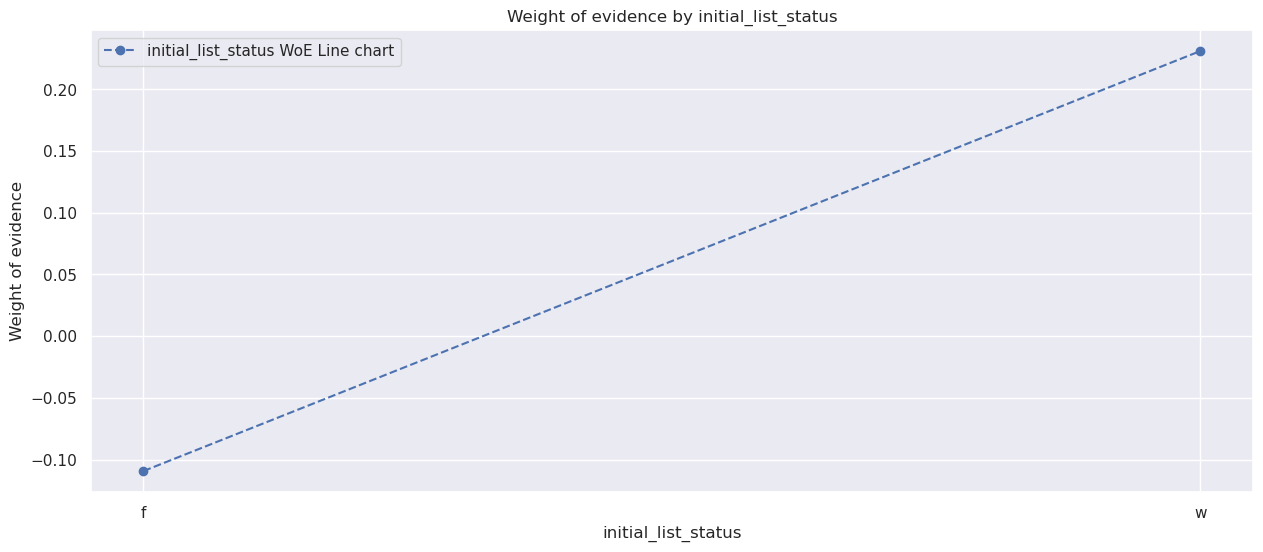

In [80]:
plot_woe(initial_list_status_we)

In [81]:
if input_data == "train":
    list_of_dummy_variables.extend(["initial_list_status:f", "initial_list_status:w"])
    list_of_ref_categories.append("initial_list_status:f")

Lets do for continous variables.

In [82]:
def compute_woe_iv_continous(df, variable_name, target_df):
    copy_df = pd.concat([df[variable_name], target_df], axis=1)
    copy_df = pd.concat([copy_df.groupby(variable_name, as_index=False)[copy_df.columns.values[1]].count(),
                         copy_df.groupby(copy_df[variable_name], as_index=False)[copy_df.columns.values[1]].mean()
                         ], axis=1)
    
    copy_df = copy_df.iloc[:, [0,1,3]]
    copy_df.columns = [copy_df.columns.values[0], "n_observation", "prop_good"]
    copy_df["prop_n_observation"] = copy_df["n_observation"] / copy_df["n_observation"].sum()
    # it returns the proprtion of good loans from df
    copy_df["n_good"] = copy_df["prop_good"] * copy_df["n_observation"]
    copy_df["n_bad"] = (1- copy_df["prop_good"]) * copy_df["n_observation"]
    
    copy_df["prop_n_good"] = copy_df["n_good"] / copy_df["n_good"].sum()
    copy_df["prop_n_bad"] = copy_df["n_bad"] / copy_df["n_bad"].sum()
    
    copy_df["woe"] = np.log(copy_df["prop_n_good"] / copy_df["prop_n_bad"])
    copy_df["iv"] = ((copy_df["prop_n_good"] - copy_df["prop_n_bad"]) * copy_df["woe"]).sum()
    
    # copy_df = copy_df.sort_values(["woe"])
    # copy_df = copy_df.reset_index(drop=True)
    return copy_df

In [83]:
term_woe = compute_woe_iv_continous(x_train_prep, "term", y_train_prep)
term_woe

,term,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,36.0,270269,0.902834,0.724527,244008.0,26261.0,0.734314,0.644695,0.130159,0.037713
1,60.0,102759,0.859156,0.275473,88286.0,14473.0,0.265686,0.355305,-0.290660,0.037713


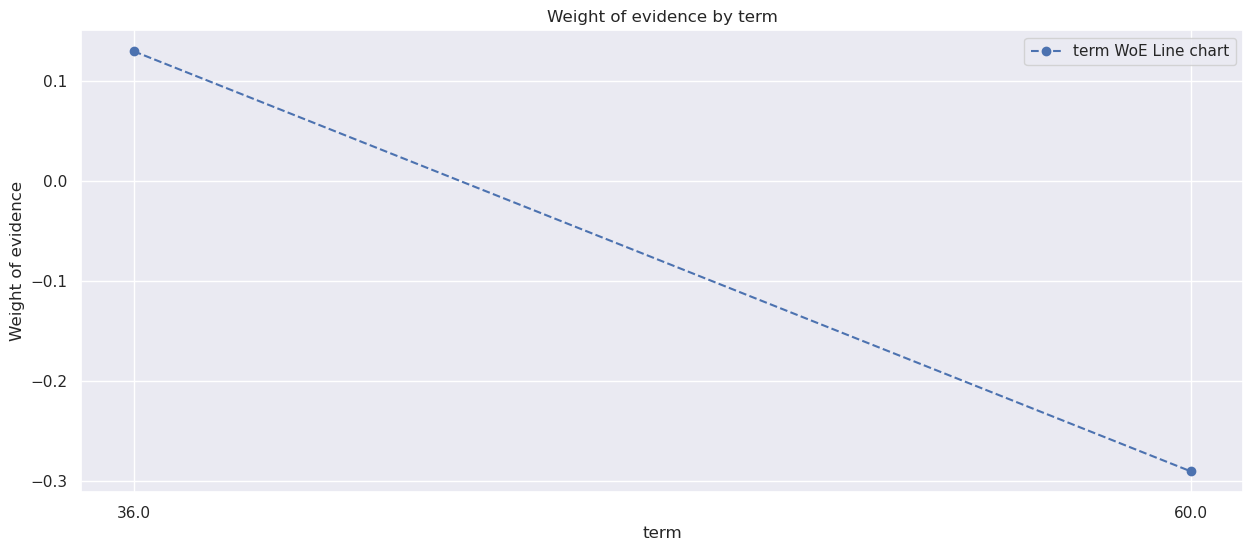

In [84]:
plot_woe(term_woe)

In [85]:
x_train_prep["term:36"] = np.where((x_train_prep["term"] == 36), 1, 0)
x_train_prep["term:60"] = np.where((x_train_prep["term"] == 60), 1, 0)

In [86]:
if input_data == "train":
    list_of_dummy_variables.extend(["term:36", "term:60"])
    list_of_ref_categories.append("term:60")

In [87]:
emp_length_woe = compute_woe_iv_continous(x_train_prep, "emp_length", y_train)
emp_length_woe

,emp_length,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,0.0,16701,0.867732,0.044771,14492.0,2209.0,0.043612,0.054230,-0.217900,0.007316
1,1.0,52806,0.884199,0.141560,46691.0,6115.0,0.140511,0.150120,-0.066150,0.007316
2,2.0,33070,0.891382,0.088653,29478.0,3592.0,0.088711,0.088182,0.005978,0.007316
3,3.0,29243,0.891495,0.078394,26070.0,3173.0,0.078455,0.077896,0.007151,0.007316
4,4.0,22502,0.890010,0.060323,20027.0,2475.0,0.060269,0.060760,-0.008116,0.007316
5,5.0,24705,0.883748,0.066228,21833.0,2872.0,0.065704,0.070506,-0.070543,0.007316
6,6.0,20930,0.881844,0.056108,18457.0,2473.0,0.055544,0.060711,-0.088945,0.007316
7,7.0,21005,0.888360,0.056309,18660.0,2345.0,0.056155,0.057569,-0.024860,0.007316
8,8.0,17902,0.890627,0.047991,15944.0,1958.0,0.047982,0.048068,-0.001798,0.007316
9,9.0,14365,0.886878,0.038509,12740.0,1625.0,0.038340,0.039893,-0.039718,0.007316


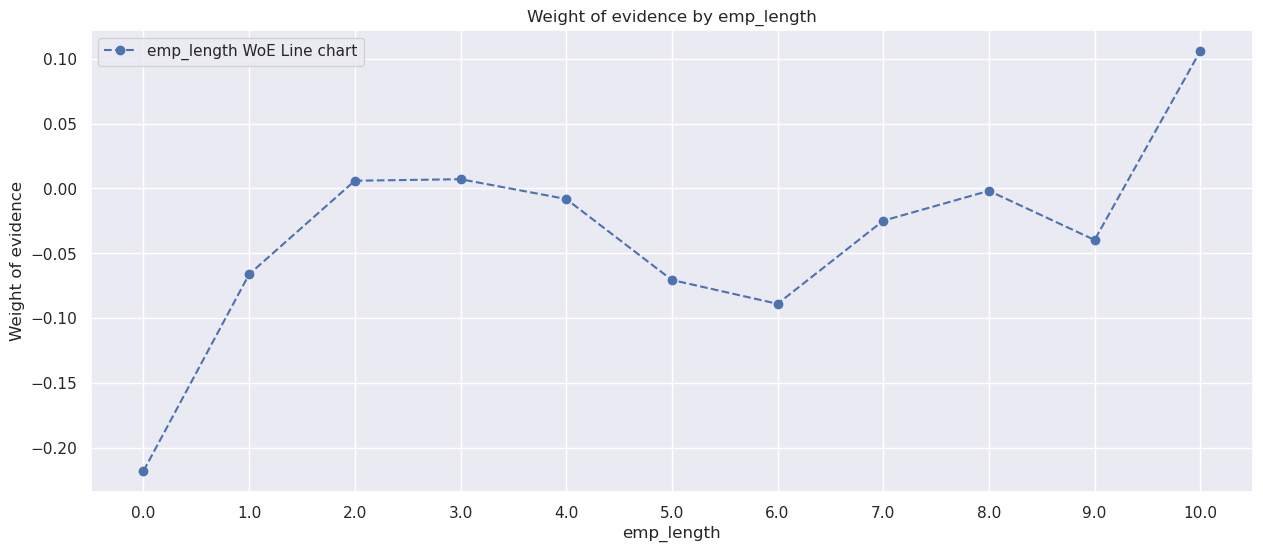

In [88]:
plot_woe(emp_length_woe)

In [89]:
x_train_prep["emp_length:0"] = np.where((x_train_prep["emp_length"] == 0), 1, 0)
x_train_prep["emp_length:1"] = np.where((x_train_prep["emp_length"] == 1), 1, 0)
x_train_prep["emp_length:2_4"] = np.where((x_train_prep["emp_length"].isin(range(2,5))), 1, 0)
x_train_prep["emp_length:5_6"] = np.where((x_train_prep["emp_length"].isin(range(5,7))), 1, 0)
x_train_prep["emp_length:7_9"] = np.where((x_train_prep["emp_length"].isin(range(7, 10))), 1, 0)
x_train_prep["emp_length:10"] = np.where((x_train_prep["emp_length"] == 10), 1, 0)

In [90]:
if input_data == "train":
    list_of_dummy_variables.extend(["emp_length:0", "emp_length:1", "emp_length:2_4", "emp_length:5_6", "emp_length:7_9", "emp_length:10"])
    list_of_ref_categories.append("emp_length:0")

In [91]:
x_train_prep["months_since_issued_date"].unique()

array([148., 121., 123., 158., 132., 129., 150., 133., 122., 128., 130.,
       146., 125., 136., 126., 184., 120., 170., 164., 118., 149., 151.,
       137., 145., 154., 142., 143., 127., 139., 155., 160., 167., 201.,
       134., 117., 135., 124., 189., 205., 152., 116., 172., 140., 162.,
       204., 138., 147., 161., 175., 168., 157., 171., 177., 173., 198.,
       159., 141., 207., 163., 186., 166., 185., 187., 190., 153., 191.,
       178., 182., 174., 196., 176., 180., 188., 193., 192., 165., 179.,
       211., 183., 202., 203., 212., 208., 197., 200., 213., 199., 209.,
       195., 210., 214.])

In [92]:
# Lets do fine and coarse classing 
x_train_prep["months_since_issued_date_factor"] = pd.cut(x_train_prep["months_since_issued_date"], 50)

In [93]:
cat_months_since_issued_date_factor_woe = compute_woe_iv_continous(x_train_prep, "months_since_issued_date_factor", y_train_prep)
cat_months_since_issued_date_factor_woe

,months_since_issued_date_factor,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,"(115.902, 117.96]",28217,0.942021,0.075643,26581.0,1636.0,0.079992,0.040163,0.688985,0.112548
1,"(117.96, 119.92]",31129,0.930129,0.083449,28954.0,2175.0,0.087134,0.053395,0.489723,0.112548
2,"(119.92, 121.88]",23484,0.920371,0.062955,21614.0,1870.0,0.065045,0.045908,0.348446,0.112548
3,"(121.88, 123.84]",37208,0.914642,0.099746,34032.0,3176.0,0.102415,0.077969,0.272722,0.112548
4,"(123.84, 125.8]",30547,0.904835,0.081889,27640.0,2907.0,0.083179,0.071365,0.153185,0.112548
5,"(125.8, 127.76]",25438,0.900307,0.068193,22902.0,2536.0,0.068921,0.062258,0.101679,0.112548
6,"(127.76, 129.72]",24542,0.897237,0.065791,22020.0,2522.0,0.066267,0.061914,0.067942,0.112548
7,"(129.72, 131.68]",11771,0.888200,0.031555,10455.0,1316.0,0.031463,0.032307,-0.026473,0.112548
8,"(131.68, 133.64]",21628,0.885704,0.057980,19156.0,2472.0,0.057648,0.060686,-0.051369,0.112548
9,"(133.64, 135.6]",19632,0.875306,0.052629,17184.0,2448.0,0.051713,0.060097,-0.150250,0.112548


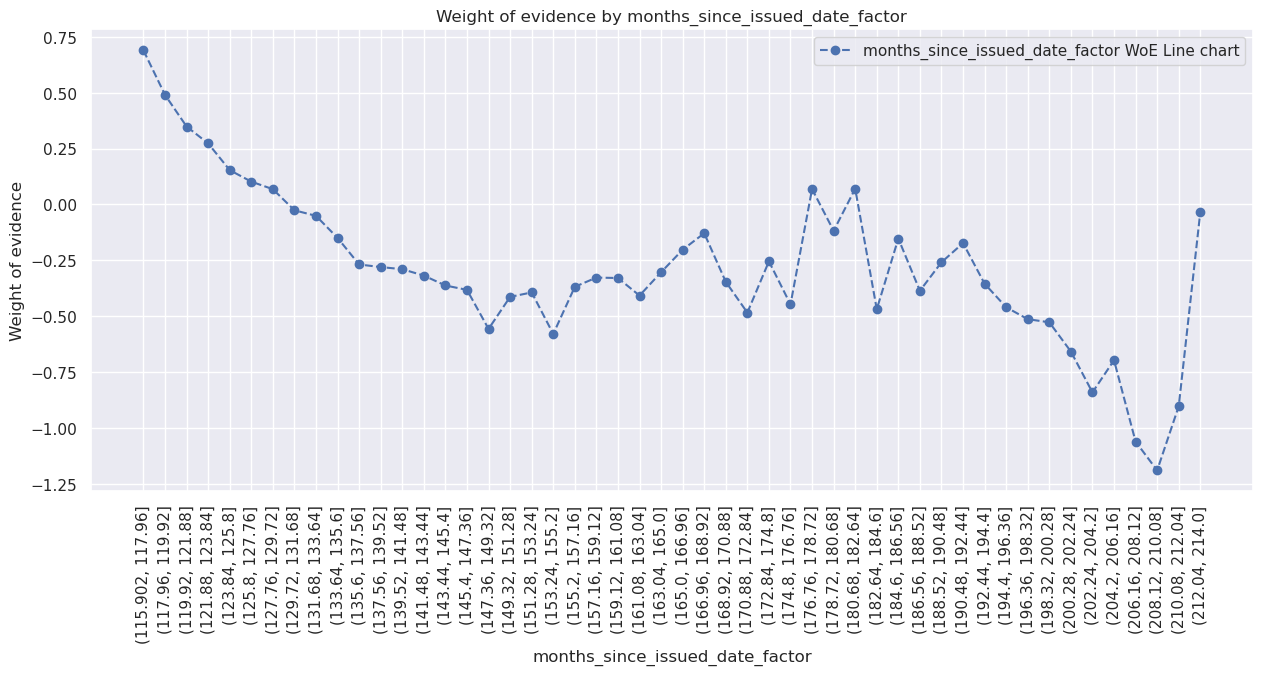

In [94]:
plot_woe(cat_months_since_issued_date_factor_woe, 90)

In [95]:
x_train_prep["months_since_issued_date:<117"] = np.where(x_train_prep["months_since_issued_date"].isin(range(117)), 1,0)
x_train_prep["months_since_issued_date:117_119"] = np.where(x_train_prep["months_since_issued_date"].isin(range(117,119)), 1,0)
x_train_prep["months_since_issued_date:119_123"] = np.where(x_train_prep["months_since_issued_date"].isin(range(119, 123)), 1,0)
x_train_prep["months_since_issued_date:123_131"] = np.where(x_train_prep["months_since_issued_date"].isin(range(123, 131)), 1,0)
x_train_prep["months_since_issued_date:131_149"] = np.where(x_train_prep["months_since_issued_date"].isin(range(131, 149)), 1,0)
x_train_prep["months_since_issued_date:149_172"] = np.where(x_train_prep["months_since_issued_date"].isin(range(149, 172)), 1,0)
x_train_prep["months_since_issued_date:>172"] = np.where(x_train_prep["months_since_issued_date"].isin(range(172, int(x_train_prep["months_since_issued_date"].max()))), 1,0)


In [96]:
if input_data == "train":
    list_of_dummy_variables.extend(["months_since_issued_date:<117", "months_since_issued_date:117_119", "months_since_issued_date:119_123", 
                                "months_since_issued_date:123_131", "months_since_issued_date:131_149", "months_since_issued_date:149_172", "months_since_issued_date:>172"])
    list_of_ref_categories.append("months_since_issued_date:>172")

In [97]:
x_train_prep["int_rate_factor"] = pd.cut(x_train_prep["int_rate"], 50)

int_rate_factor_woe = compute_woe_iv_continous(x_train_prep, "int_rate_factor", y_train_prep)
int_rate_factor_woe

,int_rate_factor,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,"(5.399, 5.833]",781,0.962868,0.002094,752.0,29.0,0.002263,0.000712,1.156483,0.346291
1,"(5.833, 6.246]",8429,0.981611,0.022596,8274.0,155.0,0.024900,0.003805,1.878491,0.346291
2,"(6.246, 6.658]",7832,0.970378,0.020996,7600.0,232.0,0.022871,0.005695,1.390209,0.346291
3,"(6.658, 7.071]",1875,0.966933,0.005026,1813.0,62.0,0.005456,0.001522,1.276647,0.346291
4,"(7.071, 7.484]",3191,0.977123,0.008554,3118.0,73.0,0.009383,0.001792,1.655531,0.346291
5,"(7.484, 7.897]",12703,0.962529,0.034054,12227.0,476.0,0.036796,0.011686,1.147027,0.346291
6,"(7.897, 8.31]",9762,0.948883,0.026170,9263.0,499.0,0.027876,0.012250,0.822220,0.346291
7,"(8.31, 8.722]",6602,0.965011,0.017698,6371.0,231.0,0.019173,0.005671,1.218137,0.346291
8,"(8.722, 9.135]",9557,0.936905,0.025620,8954.0,603.0,0.026946,0.014803,0.598981,0.346291
9,"(9.135, 9.548]",6645,0.965989,0.017814,6419.0,226.0,0.019317,0.005548,1.247526,0.346291


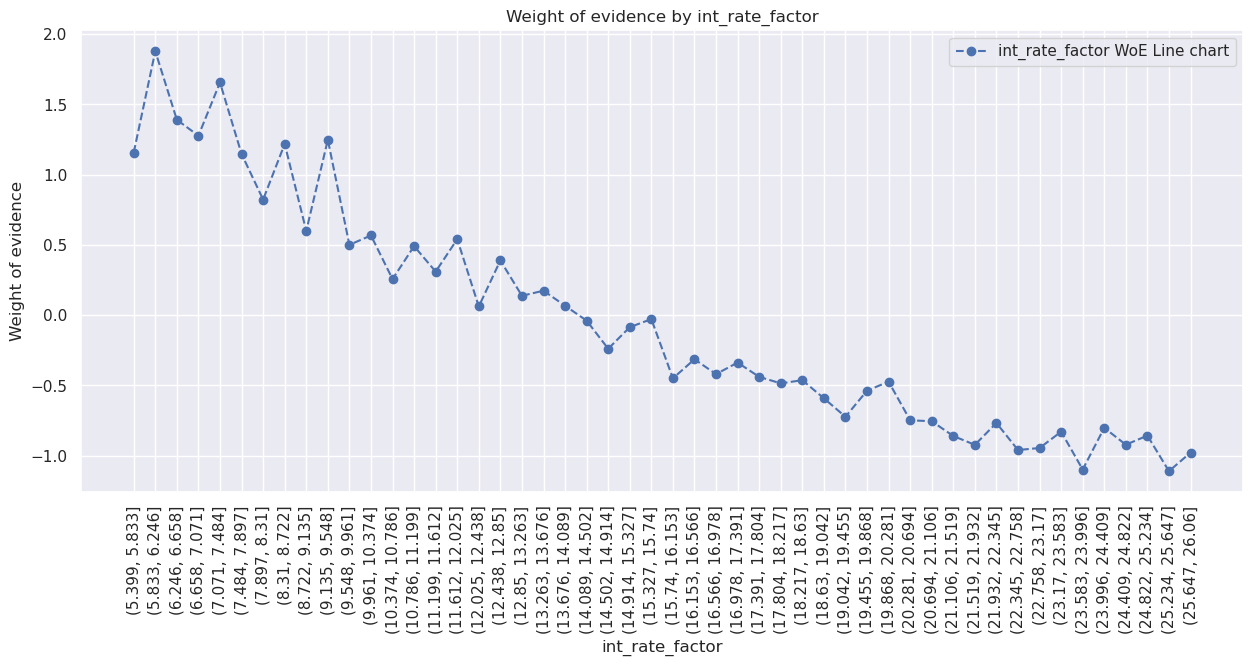

In [98]:
plot_woe(int_rate_factor_woe, 90)

In [99]:
x_train_prep["int_rate:<9.54"] = np.where((x_train_prep["int_rate"]<= 9.548), 1, 0)
x_train_prep["int_rate:9.54_12.025"] = np.where((x_train_prep["int_rate"]> 9.548) & (x_train_prep["int_rate"]<=12.025), 1, 0)
x_train_prep["int_rate:12.025_15.74"] = np.where((x_train_prep["int_rate"]> 12.025) & (x_train_prep["int_rate"]<=15.74), 1, 0)
x_train_prep["int_rate:15.74_20.281"] = np.where((x_train_prep["int_rate"]> 15.74) & (x_train_prep["int_rate"]<=20.281), 1, 0)
x_train_prep["int_rate:>20.281"] = np.where((x_train_prep["int_rate"] > 20.281), 1, 0)

In [100]:
if input_data == "train":
    list_of_dummy_variables.extend(["int_rate:<9.54", "int_rate:9.54_12.025", "int_rate:12.025_15.74", 
                                "int_rate:15.74_20.281", "int_rate:>20.281"])
    list_of_ref_categories.append("int_rate:>20.281")

In [101]:
x_train_prep["funded_amnt_factor"] = pd.cut(x_train_prep["funded_amnt"], 50)
funded_amount_woe = compute_woe_iv_continous(x_train_prep, "funded_amnt_factor", y_train_prep)
funded_amount_woe

,funded_amnt_factor,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,"(465.5, 1190.0]",1238,0.903877,0.003319,1119.0,119.0,0.003367,0.002921,0.142110,0.014077
1,"(1190.0, 1880.0]",3070,0.905863,0.008230,2781.0,289.0,0.008369,0.007095,0.165182,0.014077
2,"(1880.0, 2570.0]",5973,0.894693,0.016012,5344.0,629.0,0.016082,0.015442,0.040641,0.014077
3,"(2570.0, 3260.0]",7266,0.891687,0.019478,6479.0,787.0,0.019498,0.019320,0.009136,0.014077
4,"(3260.0, 3950.0]",4808,0.890183,0.012889,4280.0,528.0,0.012880,0.012962,-0.006345,0.014077
5,"(3950.0, 4640.0]",9024,0.888409,0.024191,8017.0,1007.0,0.024126,0.024721,-0.024368,0.014077
6,"(4640.0, 5330.0]",15940,0.892597,0.042731,14228.0,1712.0,0.042818,0.042029,0.018593,0.014077
7,"(5330.0, 6020.0]",17062,0.905990,0.045739,15458.0,1604.0,0.046519,0.039377,0.166669,0.014077
8,"(6020.0, 6710.0]",6809,0.884418,0.018253,6022.0,787.0,0.018123,0.019320,-0.064011,0.014077
9,"(6710.0, 7400.0]",11792,0.895692,0.031612,10562.0,1230.0,0.031785,0.030196,0.051291,0.014077


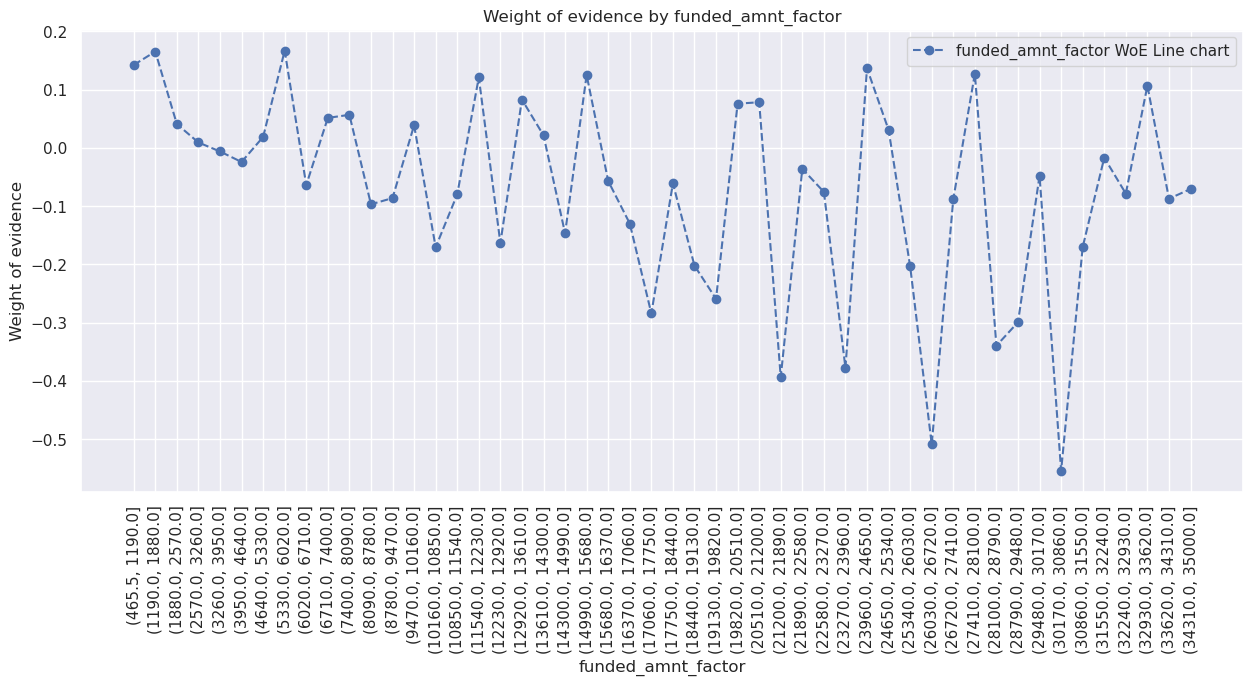

In [102]:
plot_woe(funded_amount_woe, 90)

The chart shows very different WoE on each category. It appears like trens, and almost horizontal. We can not find the pattern between indepndent and dependent variable. Hence, we will not use this varaible as predicator.

In [103]:
x_train_prep["annual_inc_factor"] = pd.cut(x_train_prep["annual_inc"], 105)
annual_inc_woe = compute_woe_iv_continous(x_train_prep, "annual_inc_factor", y_train_prep)
annual_inc_woe

,annual_inc_factor,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,"(-5498.0, 73409.524]",231149,0.875699,0.619656,202417.0,28732.0,0.609150,0.705357,-0.146639,inf
1,"(73409.524, 144819.048]",120706,0.913550,0.323584,110271.0,10435.0,0.331848,0.256174,0.258818,inf
2,"(144819.048, 216228.571]",15858,0.924518,0.042512,14661.0,1197.0,0.044121,0.029386,0.406415,inf
3,"(216228.571, 287638.095]",3140,0.928025,0.008418,2914.0,226.0,0.008769,0.005548,0.457790,inf
4,"(287638.095, 359047.619]",1125,0.931556,0.003016,1048.0,77.0,0.003154,0.001890,0.511876,inf
...,...,...,...,...,...,...,...,...,...,...
100,"(7142952.381, 7214361.905]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
101,"(7214361.905, 7285771.429]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
102,"(7285771.429, 7357180.952]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
103,"(7357180.952, 7428590.476]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf


Majority of annual income samples are from < 144000. Here, we will split the data < 144000 and > 144000, and further categorise by usng WoE method.

In [104]:
annual_income_df = x_train_prep.loc[x_train_prep["annual_inc"] <= 144000, :]

In [105]:
annual_income_df["annual_inc_factor"] = pd.cut(annual_income_df["annual_inc"], 50)
annual_inc_temp_woe = compute_woe_iv_continous(annual_income_df, "annual_inc_factor", y_train_prep[annual_income_df.index])
annual_inc_temp_woe

/tmp/ipykernel_13001/2615684705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_income_df["annual_inc_factor"] = pd.cut(annual_income_df["annual_inc"], 50)


,annual_inc_factor,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,"(1858.0, 4840.0]",18,0.777778,0.000051,14.0,4.0,0.000045,0.000102,-0.824592,0.053299
1,"(4840.0, 7680.0]",39,0.871795,0.000111,34.0,5.0,0.000109,0.000128,-0.160433,0.053299
2,"(7680.0, 10520.0]",315,0.853968,0.000895,269.0,46.0,0.000860,0.001175,-0.311285,0.053299
3,"(10520.0, 13360.0]",674,0.821958,0.001916,554.0,120.0,0.001772,0.003064,-0.547682,0.053299
4,"(13360.0, 16200.0]",1343,0.833954,0.003817,1120.0,223.0,0.003582,0.005694,-0.463443,0.053299
5,"(16200.0, 19040.0]",1669,0.840623,0.004744,1403.0,266.0,0.004487,0.006792,-0.414483,0.053299
6,"(19040.0, 21880.0]",2839,0.851004,0.008069,2416.0,423.0,0.007727,0.010801,-0.334859,0.053299
7,"(21880.0, 24720.0]",4098,0.852367,0.011648,3493.0,605.0,0.011172,0.015448,-0.324067,0.053299
8,"(24720.0, 27560.0]",6719,0.852061,0.019098,5725.0,994.0,0.018311,0.025380,-0.326495,0.053299
9,"(27560.0, 30400.0]",10537,0.857170,0.029950,9032.0,1505.0,0.028888,0.038428,-0.285374,0.053299


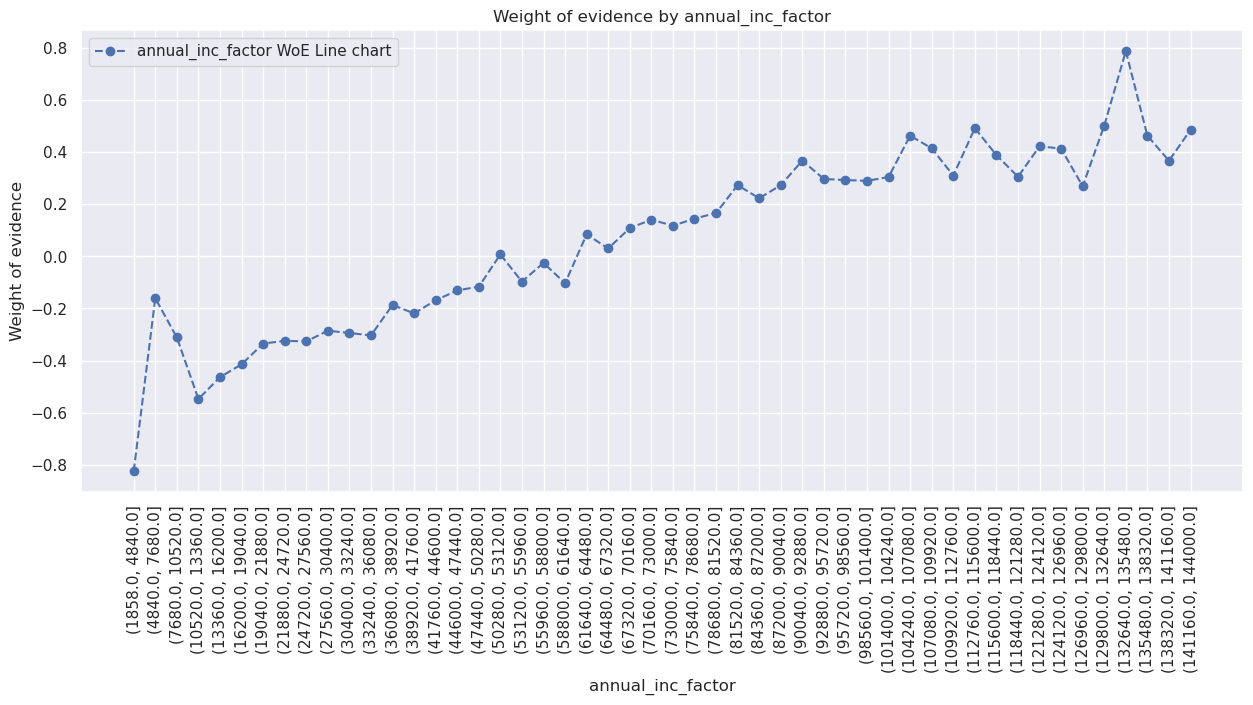

In [106]:
plot_woe(annual_inc_temp_woe, 90)

In [107]:
x_train_prep["annual_inc:<20K"] = np.where((x_train_prep["annual_inc"] <= 20000), 1, 0)
x_train_prep["annual_inc:<20K_30K"] = np.where((x_train_prep["annual_inc"] > 20000) & (x_train_prep["annual_inc"] >= 30000) , 1, 0)
x_train_prep["annual_inc:<30K_40K"] = np.where((x_train_prep["annual_inc"] > 30000) & (x_train_prep["annual_inc"] <= 40000) , 1, 0)
x_train_prep["annual_inc:<40K_50K"] = np.where((x_train_prep["annual_inc"] > 40000) & (x_train_prep["annual_inc"] <= 50000) , 1, 0)
x_train_prep["annual_inc:<50K_60K"] = np.where((x_train_prep["annual_inc"] > 50000) & (x_train_prep["annual_inc"] <= 60000) , 1, 0)
x_train_prep["annual_inc:<60K_70K"] = np.where((x_train_prep["annual_inc"] > 60000) & (x_train_prep["annual_inc"] <= 70000) , 1, 0)
x_train_prep["annual_inc:<70K_80K"] = np.where((x_train_prep["annual_inc"] > 70000) & (x_train_prep["annual_inc"] <= 80000) , 1, 0)
x_train_prep["annual_inc:<80K_90K"] = np.where((x_train_prep["annual_inc"] > 80000) & (x_train_prep["annual_inc"] <= 90000) , 1, 0)
x_train_prep["annual_inc:<90K_100K"] = np.where((x_train_prep["annual_inc"] > 90000) & (x_train_prep["annual_inc"] <= 100000) , 1, 0)
x_train_prep["annual_inc:<100K_120K"] = np.where((x_train_prep["annual_inc"] > 100000) & (x_train_prep["annual_inc"] <= 120000) , 1, 0)
x_train_prep["annual_inc:<120K_140K"] = np.where((x_train_prep["annual_inc"] > 120000) & (x_train_prep["annual_inc"] <= 140000) , 1, 0)
x_train_prep["annual_inc:>140K"] = np.where((x_train_prep["annual_inc"] > 140000), 1, 0)

In [108]:
if input_data == "train":
    list_of_dummy_variables.extend(["annual_inc:<20K", "annual_inc:<20K_30K", "annual_inc:<30K_40K", "annual_inc:<40K_50K", "annual_inc:<50K_60K", "annual_inc:<60K_70K",
                                "annual_inc:<70K_80K", "annual_inc:<80K_90K", "annual_inc:<90K_100K", "annual_inc:<100K_120K", "annual_inc:<120K_140K", "annual_inc:>140K"])
    list_of_ref_categories.append("annual_inc:<20K")

In [109]:
mths_since_last_delinq_df = x_train_prep[pd.notnull(x_train_prep["mths_since_last_delinq"])]
mths_since_last_delinq_df['mths_since_last_delinq_factor'] = pd.cut(mths_since_last_delinq_df["mths_since_last_delinq"], 50)
mths_since_last_delinq_woe = compute_woe_iv_continous(mths_since_last_delinq_df, "mths_since_last_delinq_factor", y_train_prep[mths_since_last_delinq_df.index])
mths_since_last_delinq_woe

/tmp/ipykernel_13001/1404636225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mths_since_last_delinq_df['mths_since_last_delinq_factor'] = pd.cut(mths_since_last_delinq_df["mths_since_last_delinq"], 50)


,mths_since_last_delinq_factor,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,"(-0.188, 3.76]",5277,0.872086,0.030589,4602.0,675.0,0.029896,0.036325,-0.194784,inf
1,"(3.76, 7.52]",11045,0.886464,0.064024,9791.0,1254.0,0.063606,0.067485,-0.059192,inf
2,"(7.52, 11.28]",13308,0.892846,0.077142,11882.0,1426.0,0.077190,0.076741,0.005834,inf
3,"(11.28, 15.04]",13347,0.886416,0.077368,11831.0,1516.0,0.076859,0.081584,-0.059670,inf
4,"(15.04, 18.8]",9304,0.896604,0.053932,8342.0,962.0,0.054193,0.051771,0.045726,inf
5,"(18.8, 22.56]",11717,0.892464,0.067919,10457.0,1260.0,0.067933,0.067808,0.001842,inf
6,"(22.56, 26.32]",10802,0.896038,0.062615,9679.0,1123.0,0.062878,0.060435,0.039637,inf
7,"(26.32, 30.08]",10555,0.895973,0.061183,9457.0,1098.0,0.061436,0.059089,0.038947,inf
8,"(30.08, 33.84]",7545,0.898343,0.043736,6778.0,767.0,0.044032,0.041277,0.064633,inf
9,"(33.84, 37.6]",9680,0.900310,0.056111,8715.0,965.0,0.056616,0.051932,0.086355,inf


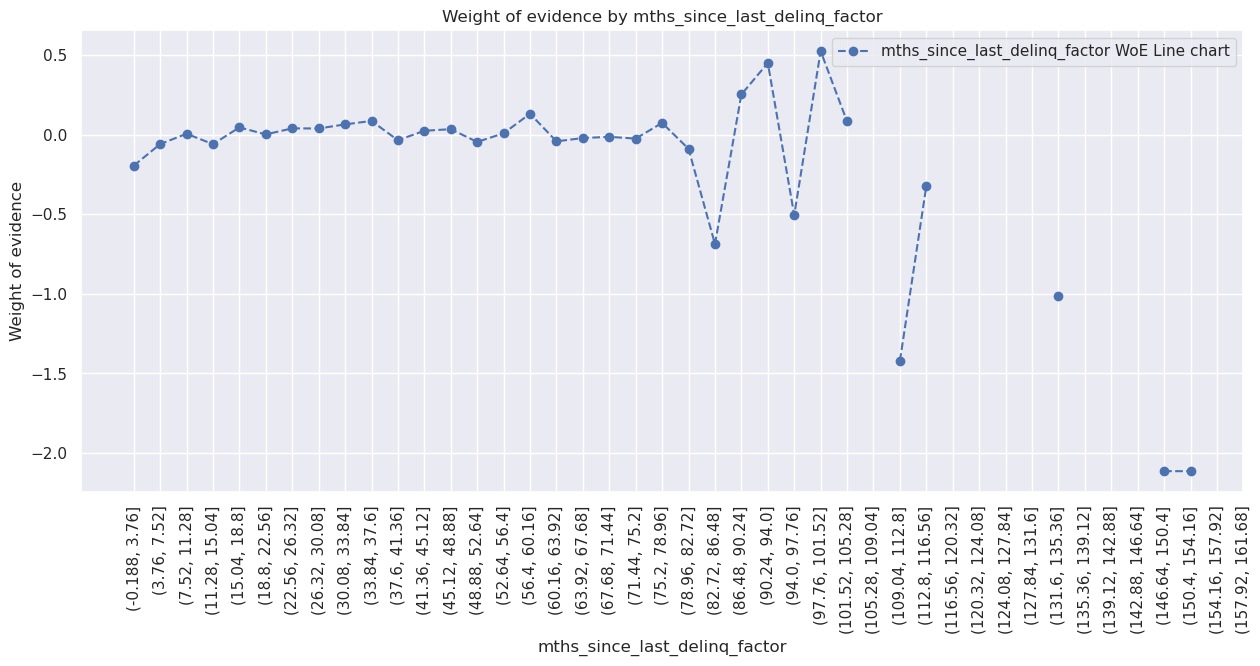

In [110]:
plot_woe(mths_since_last_delinq_woe, 90)

In [111]:
x_train_prep["mths_since_last_delinq:0_3"] = np.where((x_train_prep["mths_since_last_delinq"] >= 0 & (x_train_prep["mths_since_last_delinq"] < 4)), 1, 0)
x_train_prep["mths_since_last_delinq:4_37"] = np.where((x_train_prep["mths_since_last_delinq"] >= 4 & (x_train_prep["mths_since_last_delinq"] < 37)), 1, 0)
x_train_prep["mths_since_last_delinq:37_56"] = np.where((x_train_prep["mths_since_last_delinq"] >= 37 & (x_train_prep["mths_since_last_delinq"] < 56)), 1, 0)
x_train_prep["mths_since_last_delinq:>56"] = np.where((x_train_prep["mths_since_last_delinq"] >= 56), 1, 0)
x_train_prep["mths_since_last_delinq:missing"] = np.where((x_train_prep["mths_since_last_delinq"].isnull()), 1, 0)

In [112]:
list_of_dummy_variables.extend(["mths_since_last_delinq:0_3", "mths_since_last_delinq:4_37", "mths_since_last_delinq:37_56", "mths_since_last_delinq:>56", "mths_since_last_delinq:missing"])
list_of_ref_categories.append("mths_since_last_delinq:0_3")

In [113]:
x_train_prep["months_since_earliest_cr_line_factor"] = pd.cut(x_train_prep["months_since_earliest_cr_line"], 50)
months_since_earliest_cr_line_factor_woe = compute_woe_iv_continous(x_train_prep, "months_since_earliest_cr_line_factor", y_train_prep)
months_since_earliest_cr_line_factor_woe

,months_since_earliest_cr_line_factor,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,"(-0.715, 14.3]",24,0.916667,0.000064,22.0,2.0,0.000066,0.000049,0.298938,inf
1,"(14.3, 28.6]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
2,"(28.6, 42.9]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
3,"(42.9, 57.2]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
4,"(57.2, 71.5]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
5,"(71.5, 85.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
6,"(85.8, 100.1]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
7,"(100.1, 114.4]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
8,"(114.4, 128.7]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
9,"(128.7, 143.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf


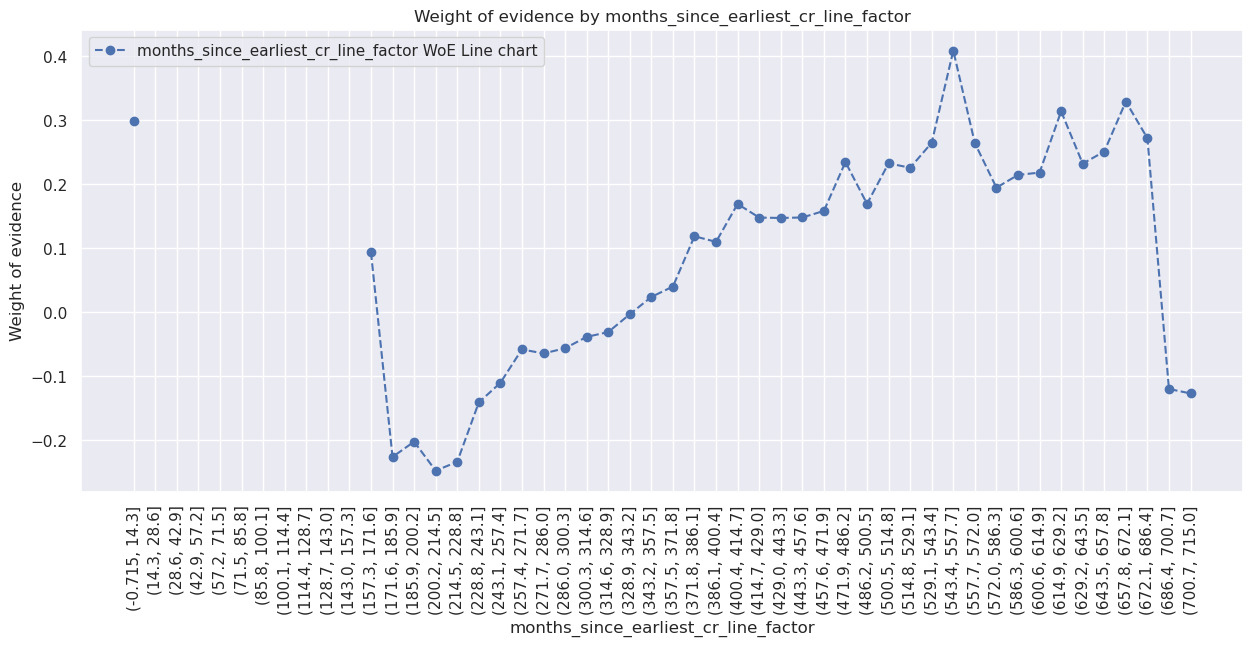

In [114]:
plot_woe(months_since_earliest_cr_line_factor_woe, 90)

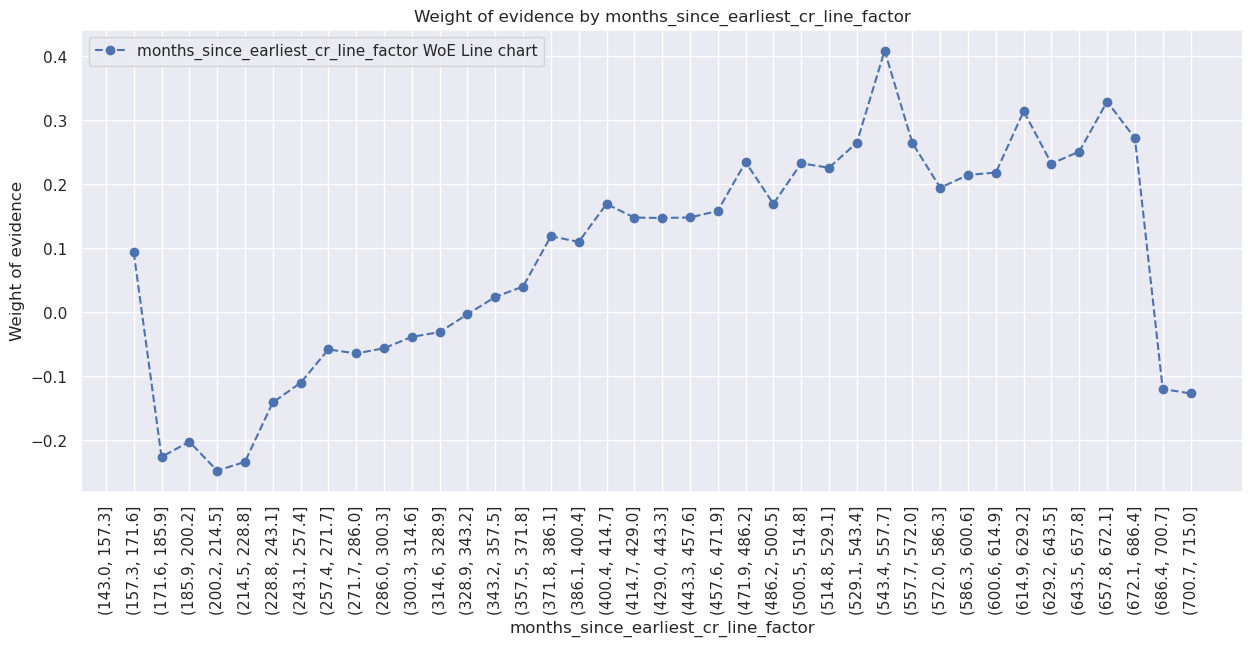

In [115]:
plot_woe(months_since_earliest_cr_line_factor_woe.iloc[7: , : ], 90)

In [116]:
x_train_prep['months_since_earliest_cr_line:<171'] = np.where(x_train_prep['months_since_earliest_cr_line'].isin(range(171)), 1, 0)
x_train_prep['months_since_earliest_cr_line:171_228'] = np.where(x_train_prep['months_since_earliest_cr_line'].isin(range(171, 228)), 1, 0)
x_train_prep['months_since_earliest_cr_line:228_257'] = np.where(x_train_prep['months_since_earliest_cr_line'].isin(range(228, 257)), 1, 0)
x_train_prep['months_since_earliest_cr_line:257_371'] = np.where(x_train_prep['months_since_earliest_cr_line'].isin(range(257, 371)), 1, 0)
x_train_prep['months_since_earliest_cr_line:371_471'] = np.where(x_train_prep['months_since_earliest_cr_line'].isin(range(371, 471)), 1, 0)
x_train_prep['months_since_earliest_cr_line:>486'] = np.where(x_train_prep['months_since_earliest_cr_line'].isin(range(486, int(x_train_prep['months_since_earliest_cr_line'].max()))), 1, 0)

In [117]:
list_of_dummy_variables.extend(["months_since_earliest_cr_line:<171", "months_since_earliest_cr_line:171_228", "months_since_earliest_cr_line:228_257",
                                "months_since_earliest_cr_line:257_371", "months_since_earliest_cr_line:371_471", "months_since_earliest_cr_line:>486"])
list_of_ref_categories.append("months_since_earliest_cr_line:<171")

In [118]:
x_train_prep["installment_factor"] = pd.cut(x_train_prep['installment'], 50)
installment_woe = compute_woe_iv_continous(x_train_prep, "installment_factor", y_train_prep)
installment_woe

,installment_factor,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,"(14.296, 43.576]",1847,0.899296,0.004951,1661.0,186.0,0.004999,0.004566,0.090471,0.013101
1,"(43.576, 71.462]",4849,0.901835,0.012999,4373.0,476.0,0.013160,0.011686,0.118830,0.013101
2,"(71.462, 99.348]",6808,0.892773,0.018251,6078.0,730.0,0.018291,0.017921,0.020429,0.013101
3,"(99.348, 127.234]",9197,0.892356,0.024655,8207.0,990.0,0.024698,0.024304,0.016081,0.013101
4,"(127.234, 155.12]",10079,0.895228,0.027019,9023.0,1056.0,0.027154,0.025924,0.046332,0.013101
5,"(155.12, 183.006]",16858,0.894590,0.045192,15081.0,1777.0,0.045385,0.043624,0.039552,0.013101
6,"(183.006, 210.892]",16895,0.902693,0.045292,15251.0,1644.0,0.045896,0.040359,0.128556,0.013101
7,"(210.892, 238.778]",15006,0.901173,0.040228,13523.0,1483.0,0.040696,0.036407,0.111368,0.013101
8,"(238.778, 266.664]",18919,0.900735,0.050717,17041.0,1878.0,0.051283,0.046104,0.106458,0.013101
9,"(266.664, 294.55]",20118,0.889005,0.053932,17885.0,2233.0,0.053823,0.054819,-0.018341,0.013101


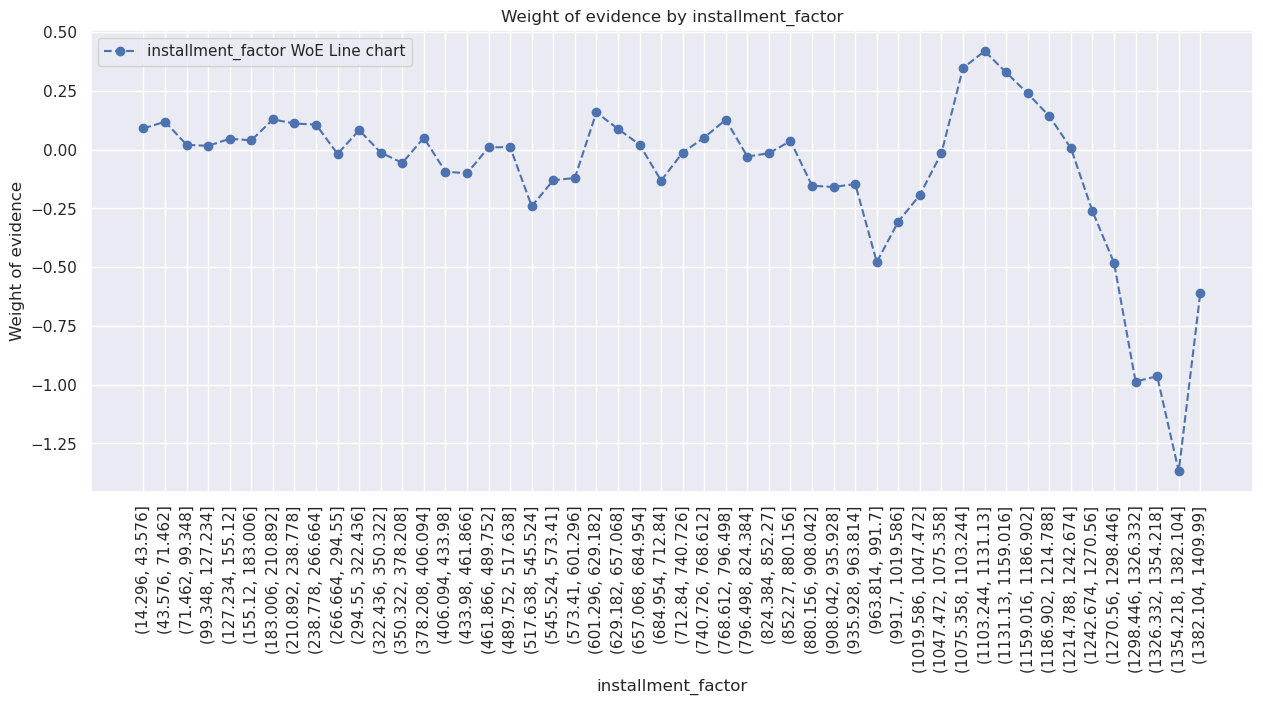

In [119]:
plot_woe(installment_woe, 90)

This feature does not contribute much to dependent variable. Hence, we omit this.

In [120]:
delinq_2years_woe = compute_woe_iv_continous(x_train_prep, "delinq_2yrs", y_train_prep)
delinq_2years_woe

,delinq_2yrs,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,0.0,306350,0.890765,0.821252,272886.0,33464.0,0.821219,0.821525,-0.000373,inf
1,1.0,44914,0.892417,0.120404,40082.0,4832.0,0.120622,0.118623,0.016710,inf
2,2.0,13146,0.889244,0.035241,11690.0,1456.0,0.035180,0.035744,-0.015916,inf
3,3.0,4534,0.883326,0.012155,4005.0,529.0,0.012053,0.012987,-0.074647,inf
4,4.0,1927,0.891541,0.005166,1718.0,209.0,0.005170,0.005131,0.007625,inf
5,5.0,979,0.891726,0.002624,873.0,106.0,0.002627,0.002602,0.009539,inf
6,6.0,499,0.889780,0.001338,444.0,55.0,0.001336,0.001350,-0.010466,inf
7,7.0,281,0.886121,0.000753,249.0,32.0,0.000749,0.000786,-0.047240,inf
8,8.0,136,0.904412,0.000365,123.0,13.0,0.000370,0.000319,0.148278,inf
9,9.0,87,0.885057,0.000233,77.0,10.0,0.000232,0.000245,-0.057737,inf


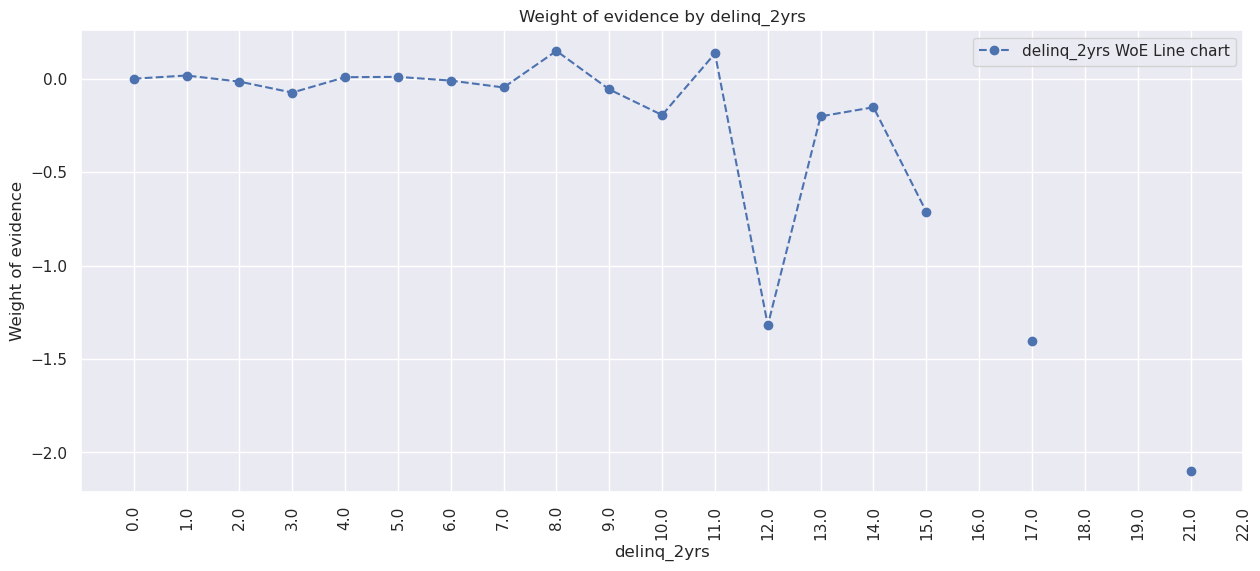

In [121]:
plot_woe(delinq_2years_woe, 90)

In [122]:
x_train_prep['delinq_2yrs:0'] = np.where((x_train_prep['delinq_2yrs'] == 0), 1, 0)
x_train_prep['delinq_2yrs:1_3'] = np.where((x_train_prep['delinq_2yrs'] >= 1) & (x_train_prep['delinq_2yrs'] < 4), 1, 0)
x_train_prep['delinq_2yrs:4_7'] = np.where((x_train_prep['delinq_2yrs'] >= 4) & (x_train_prep['delinq_2yrs'] < 7), 1, 0)
x_train_prep['delinq_2yrs:>7'] = np.where((x_train_prep['delinq_2yrs'] >= 7), 1, 0)

In [123]:
list_of_dummy_variables.extend(["delinq_2yrs:0", "delinq_2yrs:1_3", "delinq_2yrs:4_7", "delinq_2yrs:>7"])
list_of_ref_categories.append("delinq_2yrs:>7")

In [124]:
inq_last_6mths_woe = compute_woe_iv_continous(x_train_prep, "inq_last_6mths", y_train_prep)
inq_last_6mths_woe


/home/whiskey/miniconda3/envs/nlp/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,inq_last_6mths,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,0.0,193580,0.908617,0.518942,175890.0,17690.0,0.529320,0.434281,0.197902,inf
1,1.0,103868,0.884613,0.278446,91883.0,11985.0,0.276511,0.294226,-0.062097,inf
2,2.0,46255,0.863971,0.123999,39963.0,6292.0,0.120264,0.154466,-0.250282,inf
3,3.0,20027,0.841764,0.053688,16858.0,3169.0,0.050732,0.077797,-0.427548,inf
4,4.0,5776,0.845914,0.015484,4886.0,890.0,0.014704,0.021849,-0.396049,inf
5,5.0,2209,0.826618,0.005922,1826.0,383.0,0.005495,0.009402,-0.537109,inf
6,6.0,959,0.787278,0.002571,755.0,204.0,0.002272,0.005008,-0.790359,inf
7,7.0,150,0.673333,0.000402,101.0,49.0,0.000304,0.001203,-1.375657,inf
8,8.0,92,0.597826,0.000247,55.0,37.0,0.000166,0.000908,-1.702542,inf
9,9.0,37,0.648649,0.000099,24.0,13.0,0.000072,0.000319,-1.485853,inf


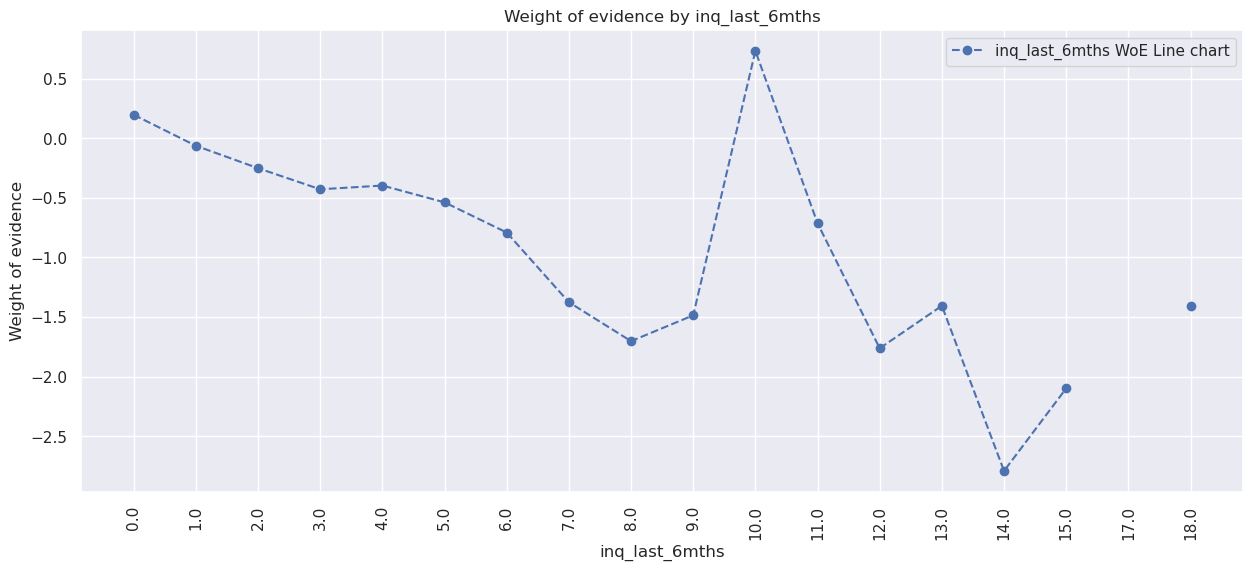

In [125]:
plot_woe(inq_last_6mths_woe, 90)

In [126]:
x_train_prep['inq_last_6mths:0'] = np.where((x_train_prep['inq_last_6mths'] == 0), 1, 0)
x_train_prep['inq_last_6mths:1_2'] = np.where((x_train_prep['inq_last_6mths'] >= 1) & (x_train_prep['inq_last_6mths'] <= 2), 1, 0)
x_train_prep['inq_last_6mths:3_6'] = np.where((x_train_prep['inq_last_6mths'] >= 3) & (x_train_prep['inq_last_6mths'] <= 6), 1, 0)
x_train_prep['inq_last_6mths:>6'] = np.where((x_train_prep['inq_last_6mths'] > 6), 1, 0)

In [127]:
if input_data == "train":
    list_of_dummy_variables.extend(["inq_last_6mths:0", "inq_last_6mths:1_2", "inq_last_6mths:3_6", "inq_last_6mths:>6"])
    list_of_ref_categories.append("inq_last_6mths:>6")

In [128]:
open_acc_woe = compute_woe_iv_continous(x_train_prep, "open_acc", y_train_prep)
open_acc_woe

/home/whiskey/miniconda3/envs/nlp/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,open_acc,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,0.0,30,0.800000,0.000080,24.0,6.0,0.000072,0.000147,-0.712663,inf
1,1.0,116,0.887931,0.000311,103.0,13.0,0.000310,0.000319,-0.029177,inf
2,2.0,1429,0.846746,0.003831,1210.0,219.0,0.003641,0.005376,-0.389653,inf
3,3.0,4423,0.869319,0.011857,3845.0,578.0,0.011571,0.014190,-0.204002,inf
4,4.0,10080,0.891667,0.027022,8988.0,1092.0,0.027048,0.026808,0.008922,inf
5,5.0,17197,0.891725,0.046101,15335.0,1862.0,0.046149,0.045711,0.009530,inf
6,6.0,24657,0.891471,0.066100,21981.0,2676.0,0.066149,0.065695,0.006898,inf
7,7.0,29994,0.889745,0.080407,26687.0,3307.0,0.080311,0.081185,-0.010822,inf
8,8.0,33463,0.891492,0.089706,29832.0,3631.0,0.089776,0.089139,0.007117,inf
9,9.0,35199,0.889940,0.094360,31325.0,3874.0,0.094269,0.095105,-0.008828,inf


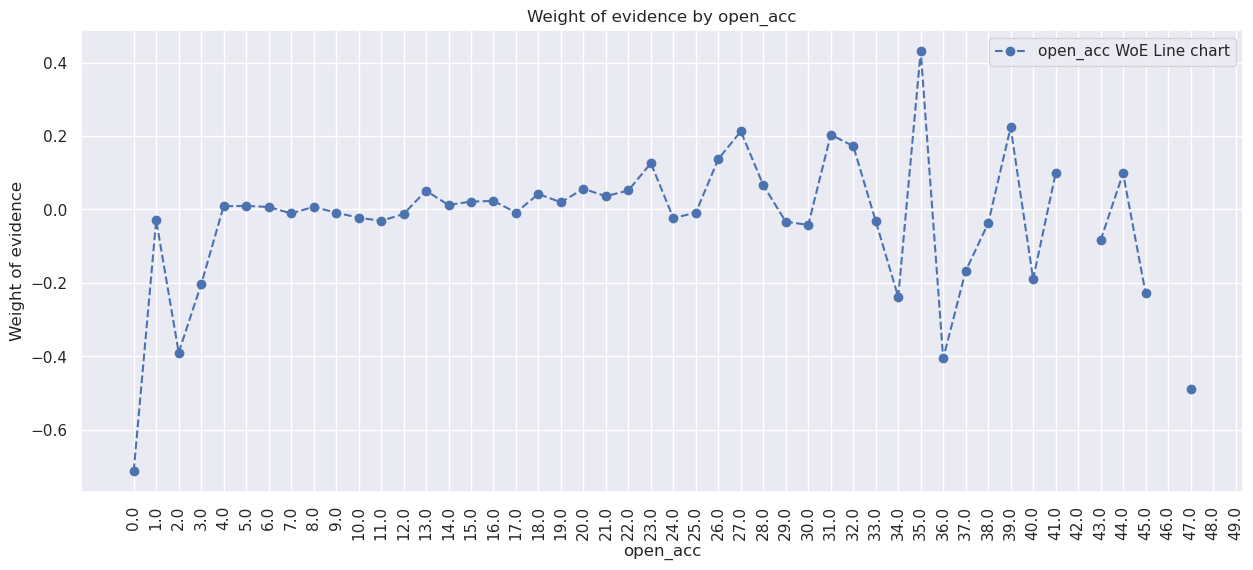

In [129]:
plot_woe(open_acc_woe, 90)

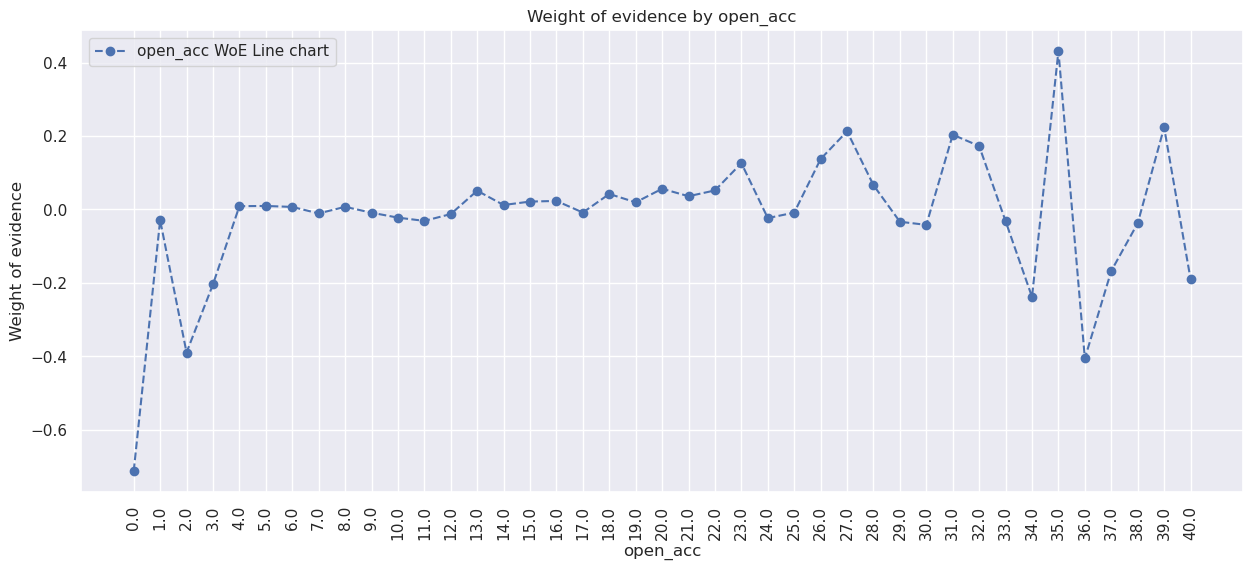

In [130]:
plot_woe(open_acc_woe.loc[:40,:], 90)

In [131]:
x_train_prep['open_acc:<4'] = np.where((x_train_prep['open_acc'] < 4), 1, 0)
x_train_prep['open_acc:4_12'] = np.where((x_train_prep['open_acc'] >= 4) & (x_train_prep['open_acc'] <= 12), 1, 0)
x_train_prep['open_acc:13_17'] = np.where((x_train_prep['open_acc'] >= 13) & (x_train_prep['open_acc'] <= 17), 1, 0)
x_train_prep['open_acc:18_22'] = np.where((x_train_prep['open_acc'] >= 18) & (x_train_prep['open_acc'] <= 22), 1, 0)
x_train_prep['open_acc:23_25'] = np.where((x_train_prep['open_acc'] >= 23) & (x_train_prep['open_acc'] <= 25), 1, 0)
x_train_prep['open_acc:26_30'] = np.where((x_train_prep['open_acc'] >= 26) & (x_train_prep['open_acc'] <= 30), 1, 0)
x_train_prep['open_acc:>=31'] = np.where((x_train_prep['open_acc'] >= 31), 1, 0)

In [132]:
if input_data == "train":
    list_of_dummy_variables.extend(["open_acc:<4", "open_acc:4_12", "open_acc:13_17", "open_acc:18_22", "open_acc:23_25", "open_acc:26_30", "open_acc:>=31" ])
    list_of_ref_categories.append("open_acc:<4")

In [133]:
pub_rec_woe = compute_woe_iv_continous(x_train_prep, "pub_rec", y_train_prep)
pub_rec_woe

,pub_rec,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,0.0,323999,0.889910,0.868565,288330.0,35669.0,0.867695,0.875657,-0.009133,inf
1,1.0,42337,0.894820,0.113496,37884.0,4453.0,0.114007,0.109319,0.041994,inf
2,2.0,4519,0.903961,0.012114,4085.0,434.0,0.012293,0.010654,0.143075,inf
3,3.0,1300,0.920769,0.003485,1197.0,103.0,0.003602,0.002529,0.353888,inf
4,4.0,421,0.909739,0.001129,383.0,38.0,0.001153,0.000933,0.211492,inf
5,5.0,222,0.905405,0.000595,201.0,21.0,0.000605,0.000516,0.159825,inf
6,6.0,116,0.913793,0.000311,106.0,10.0,0.000319,0.000245,0.261897,inf
7,7.0,47,0.936170,0.000126,44.0,3.0,0.000132,0.000074,0.586620,inf
8,8.0,24,0.958333,0.000064,23.0,1.0,0.000069,0.000025,1.036537,inf
9,9.0,14,0.857143,0.000038,12.0,2.0,0.000036,0.000049,-0.307198,inf


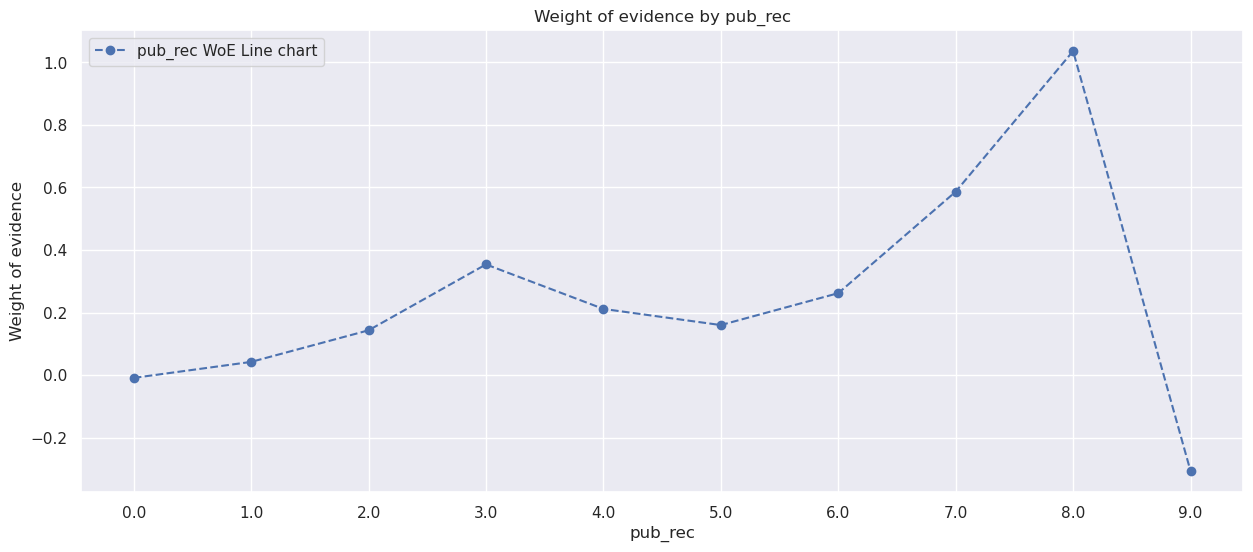

In [134]:
plot_woe(pub_rec_woe)

In [135]:
x_train_prep['pub_rec:0_2'] = np.where((x_train_prep['pub_rec'] >= 0) & (x_train_prep['pub_rec'] <= 2), 1, 0)
x_train_prep['pub_rec:3_4'] = np.where((x_train_prep['pub_rec'] >= 3) & (x_train_prep['pub_rec'] <= 4), 1, 0)
x_train_prep['pub_rec:>=5'] = np.where((x_train_prep['pub_rec'] >= 5), 1, 0)

In [136]:
if input_data == "train":
    list_of_dummy_variables.extend(["pub_rec:0_2", "pub_rec:3_4", "pub_rec:>=5"])
    list_of_ref_categories.append("pub_rec:0_2")

In [137]:
x_train_prep['total_acc_factor'] = pd.cut(x_train_prep['total_acc'], 50)
total_acc_woe = compute_woe_iv_continous(x_train_prep, "total_acc_factor", y_train_prep)
total_acc_woe

,total_acc_factor,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,"(-0.156, 3.12]",464,0.806034,0.001244,374.0,90.0,0.001126,0.002209,-0.674511,inf
1,"(3.12, 6.24]",6001,0.864523,0.016087,5188.0,813.0,0.015613,0.019959,-0.245585,inf
2,"(6.24, 9.36]",15046,0.871926,0.040335,13119.0,1927.0,0.039480,0.047307,-0.180860,inf
3,"(9.36, 12.48]",25210,0.881079,0.067582,22212.0,2998.0,0.066844,0.073599,-0.096270,inf
4,"(12.48, 15.6]",33497,0.883273,0.089798,29587.0,3910.0,0.089039,0.095989,-0.075159,inf
5,"(15.6, 18.72]",38786,0.887382,0.103976,34418.0,4368.0,0.103577,0.107232,-0.034683,inf
6,"(18.72, 21.84]",40800,0.888358,0.109375,36245.0,4555.0,0.109075,0.111823,-0.024881,inf
7,"(21.84, 24.96]",40182,0.891718,0.107718,35831.0,4351.0,0.107829,0.106815,0.009451,inf
8,"(24.96, 28.08]",47259,0.894539,0.126690,42275.0,4984.0,0.127222,0.122355,0.039006,inf
9,"(28.08, 31.2]",29702,0.897280,0.079624,26651.0,3051.0,0.080203,0.074901,0.068400,inf


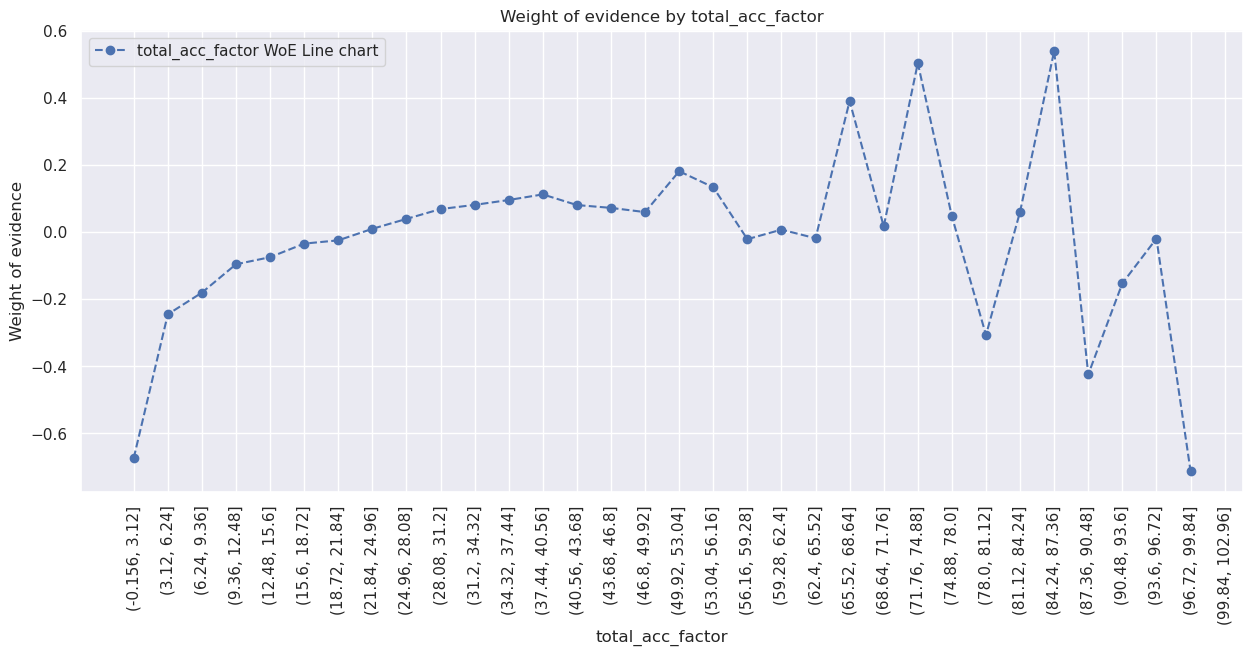

In [138]:
plot_woe(total_acc_woe, 90)

In [139]:
x_train_prep['total_acc:<=28'] = np.where((x_train_prep['total_acc'] < 28), 1, 0)
x_train_prep['total_acc:28_50'] = np.where((x_train_prep['total_acc'] >= 28) & (x_train_prep['total_acc'] < 50), 1, 0)
x_train_prep['total_acc:>=50'] = np.where((x_train_prep['total_acc'] >= 50), 1, 0)

In [140]:
if input_data == "train":
    list_of_dummy_variables.extend(["total_acc:<=28", "total_acc:28_50", "total_acc:>=50"])
    list_of_ref_categories.append("total_acc:<=28")

In [141]:
acc_now_delinq_woe = compute_woe_iv_continous(x_train_prep, "acc_now_delinq", y_train_prep)
acc_now_delinq_woe

,acc_now_delinq,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,0.0,371651,0.890785,0.996309,331061.0,40590.0,0.996289,0.996465,-0.000176,inf
1,1.0,1290,0.895349,0.003458,1155.0,135.0,0.003476,0.003314,0.047624,inf
2,2.0,73,0.917808,0.000196,67.0,6.0,0.000202,0.000147,0.313976,inf
3,3.0,9,0.777778,0.000024,7.0,2.0,0.000021,0.000049,-0.846194,inf
4,4.0,3,1.000000,0.000008,3.0,0.0,0.000009,0.000000,inf,inf
5,5.0,2,0.500000,0.000005,1.0,1.0,0.000003,0.000025,-2.098957,inf


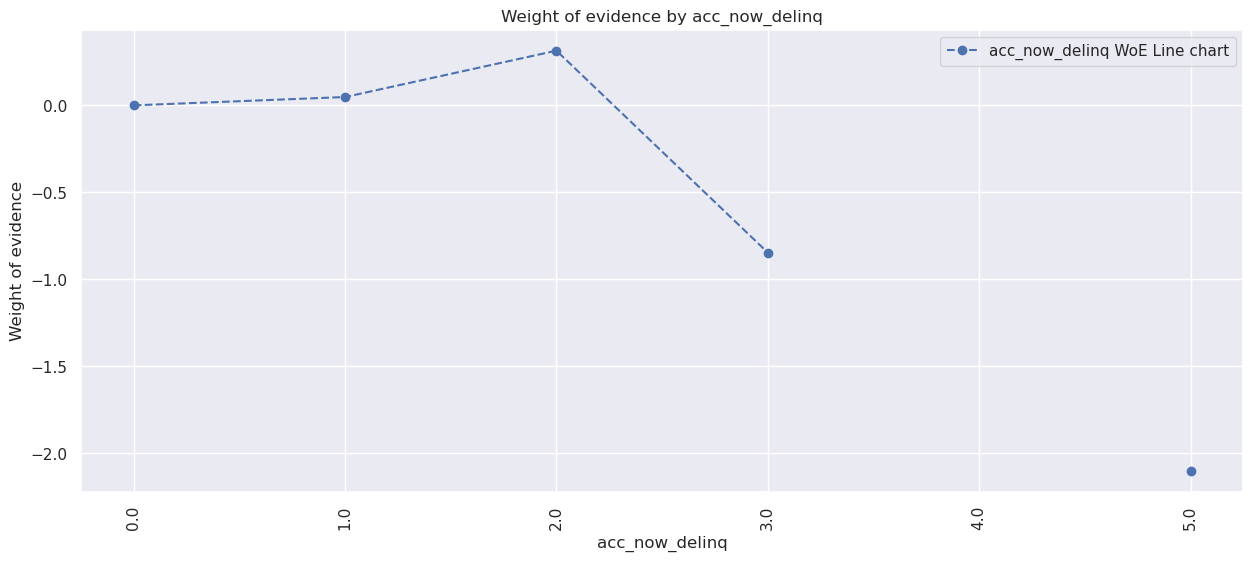

In [142]:
plot_woe(acc_now_delinq_woe, 90)

In [143]:
x_train_prep['acc_now_delinq:0'] = np.where((x_train_prep['acc_now_delinq'] == 0), 1, 0)
x_train_prep['acc_now_delinq:>=1'] = np.where((x_train_prep['acc_now_delinq'] >= 1), 1, 0)

In [144]:
if input_data == "train":
    list_of_dummy_variables.extend(["acc_now_delinq:0", "acc_now_delinq:>=1"])
    list_of_ref_categories.append("acc_now_delinq:0")

In [145]:
x_train_prep["dti_factor"] = pd.cut(x_train_prep["dti"], 50)
dti_woe = compute_woe_iv_continous(x_train_prep, "dti_factor", y_train_prep)
dti_woe

,dti_factor,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,"(-0.04, 0.8]",1558,0.895379,0.004177,1395.0,163.0,0.004198,0.004002,0.047942,0.028132
1,"(0.8, 1.6]",1970,0.899492,0.005281,1772.0,198.0,0.005333,0.004861,0.092640,0.028132
2,"(1.6, 2.399]",2549,0.908984,0.006833,2317.0,232.0,0.006973,0.005695,0.202334,0.028132
3,"(2.399, 3.199]",3232,0.912748,0.008664,2950.0,282.0,0.008878,0.006923,0.248696,0.028132
4,"(3.199, 3.999]",4107,0.913562,0.011010,3752.0,355.0,0.011291,0.008715,0.258970,0.028132
5,"(3.999, 4.799]",5006,0.913704,0.013420,4574.0,432.0,0.013765,0.010605,0.260761,0.028132
6,"(4.799, 5.599]",6032,0.912633,0.016170,5505.0,527.0,0.016567,0.012938,0.247255,0.028132
7,"(5.599, 6.398]",6824,0.911782,0.018294,6222.0,602.0,0.018724,0.014779,0.236632,0.028132
8,"(6.398, 7.198]",7786,0.916645,0.020872,7137.0,649.0,0.021478,0.015933,0.298658,0.028132
9,"(7.198, 7.998]",8787,0.913281,0.023556,8025.0,762.0,0.024150,0.018707,0.255413,0.028132


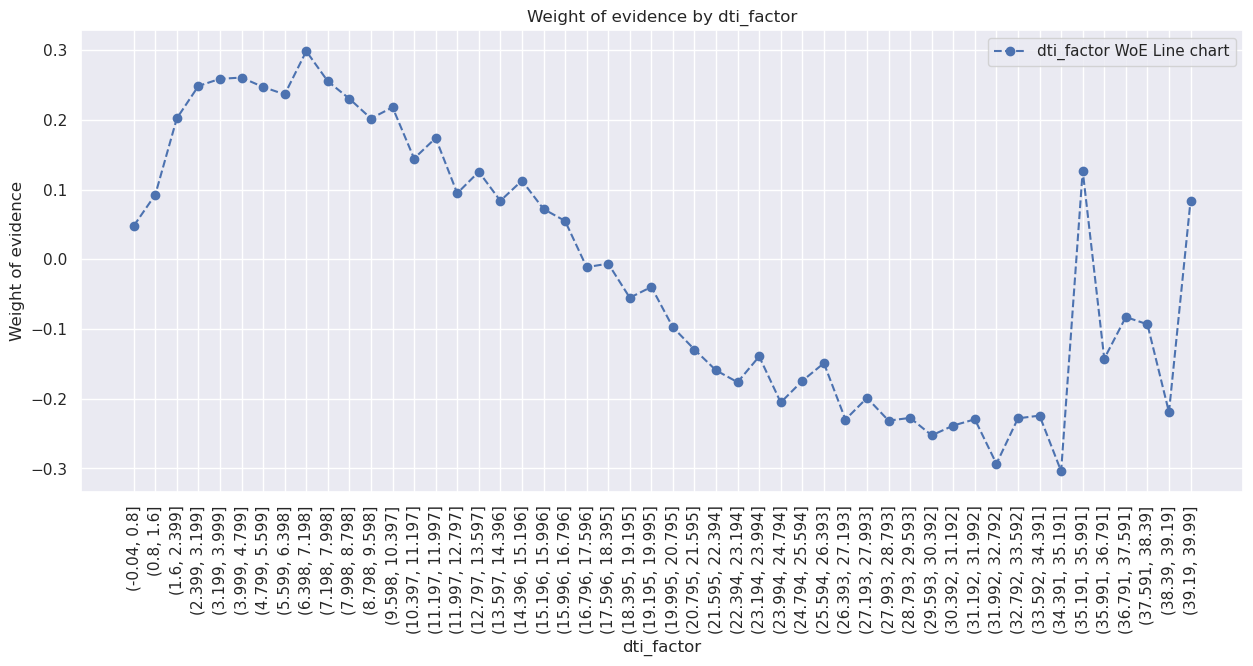

In [146]:
plot_woe(dti_woe, 90)

In [147]:
x_train_prep['dti:<=1.6'] = np.where((x_train_prep['dti'] < 1.6), 1, 0)
x_train_prep['dti:1.6_6.39'] = np.where((x_train_prep['dti'] >= 1.4) & (x_train_prep['dti'] <= 3.5), 1, 0)
x_train_prep['dti:6.39_10.39'] = np.where((x_train_prep['dti'] >= 6.39) & (x_train_prep['dti'] < 10.39), 1, 0)
x_train_prep['dti:12.97_16.79'] = np.where((x_train_prep['dti'] >= 12.97) & (x_train_prep['dti'] <= 16.79), 1, 0)
x_train_prep['dti:17.59_19.95'] = np.where((x_train_prep['dti'] >= 17.59) & (x_train_prep['dti'] <= 19.95), 1, 0)
x_train_prep['dti:20.75_23.99'] = np.where((x_train_prep['dti'] >= 20.75) & (x_train_prep['dti'] <= 23.99), 1, 0)
x_train_prep['dti:24.9_31.99'] = np.where((x_train_prep['dti'] >= 24.9) & (x_train_prep['dti'] <= 31.99), 1, 0)
x_train_prep['dti:>32'] = np.where((x_train_prep['dti'] > 32), 1, 0)

In [148]:
if input_data == "train":
    list_of_dummy_variables.extend(["dti:<=1.6", "dti:1.6_6.39", "dti:6.39_10.39", "dti:12.97_16.79", "dti:17.59_19.95", "dti:20.75_23.99", "dti:24.9_31.99", "dti:>32"])
    list_of_ref_categories.append("dti:>32")

In [149]:
x_train_prep["mths_since_last_record_factor"] = pd.cut(x_train_prep["mths_since_last_record"], 50)
mths_since_last_record_woe = compute_woe_iv_continous(x_train_prep, "mths_since_last_record_factor", y_train_prep)
mths_since_last_record_woe

/home/whiskey/miniconda3/envs/nlp/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mths_since_last_record_factor,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,"(-0.129, 2.58]",324048,0.889908,0.868696,288373.0,35675.0,0.867825,0.875804,-0.009152,inf
1,"(2.58, 5.16]",116,0.896552,0.000311,104.0,12.0,0.000313,0.000295,0.060527,inf
2,"(5.16, 7.74]",126,0.920635,0.000338,116.0,10.0,0.000349,0.000245,0.352048,inf
3,"(7.74, 10.32]",252,0.920635,0.000676,232.0,20.0,0.000698,0.000491,0.352048,inf
4,"(10.32, 12.9]",195,0.902564,0.000523,176.0,19.0,0.000530,0.000466,0.127088,inf
5,"(12.9, 15.48]",313,0.907348,0.000839,284.0,29.0,0.000855,0.000712,0.182721,inf
6,"(15.48, 18.06]",340,0.897059,0.000911,305.0,35.0,0.000918,0.000859,0.066007,inf
7,"(18.06, 20.64]",255,0.952941,0.000684,243.0,12.0,0.000731,0.000295,0.909198,inf
8,"(20.64, 23.22]",427,0.896956,0.001145,383.0,44.0,0.001153,0.001080,0.064888,inf
9,"(23.22, 25.8]",307,0.895765,0.000823,275.0,32.0,0.000828,0.000786,0.052078,inf


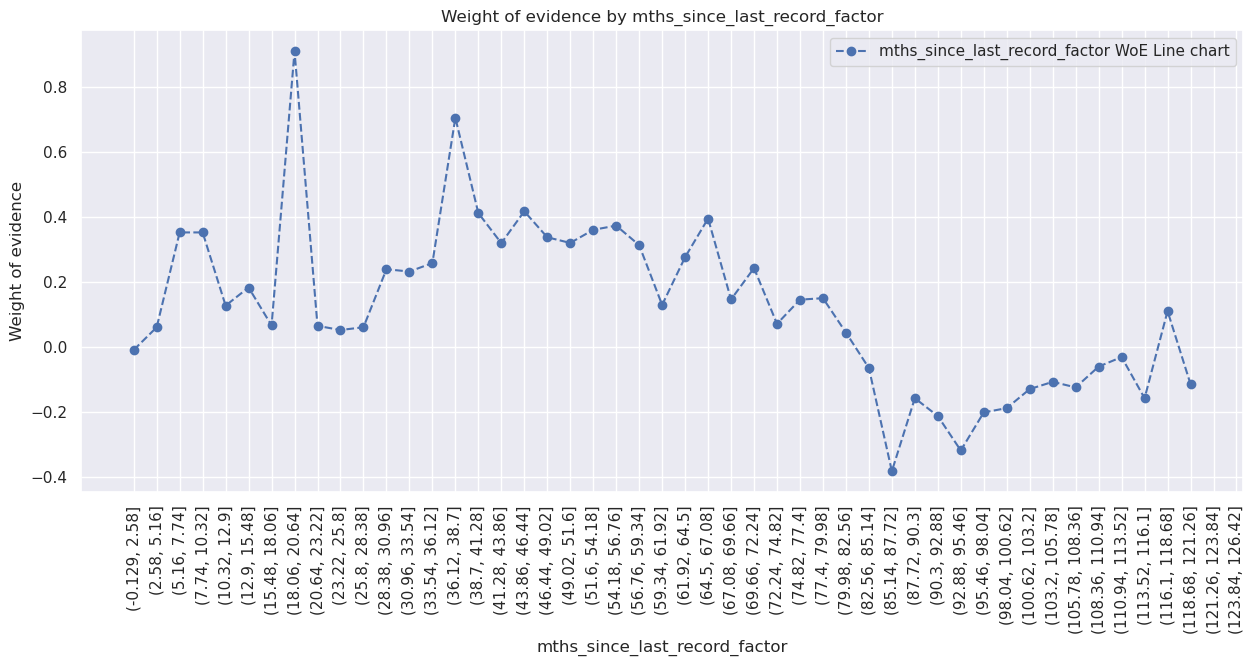

In [150]:
plot_woe(mths_since_last_record_woe, 90)

In [151]:
x_train_prep['mths_since_last_record:0_2'] = np.where((x_train_prep['mths_since_last_record'] < 2.5), 1, 0)
x_train_prep['mths_since_last_record:>2'] = np.where((x_train_prep['mths_since_last_record'] >= 2.5), 1, 0)

In [152]:
if input_data == "train":
    list_of_dummy_variables.extend(["mths_since_last_record:0_2", "mths_since_last_record:>2"])
    list_of_ref_categories.append("mths_since_last_record:0_2")

In [153]:
x_train_prep["total_rev_hi_lim_factor"] = pd.cut(x_train_prep["total_rev_hi_lim"], 2000)
total_rev_woe = compute_woe_iv_continous(x_train_prep, "total_rev_hi_lim_factor", y_train_prep)
total_rev_woe

/home/whiskey/miniconda3/envs/nlp/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,total_rev_hi_lim_factor,n_observation,prop_good,prop_n_observation,n_good,n_bad,prop_n_good,prop_n_bad,woe,iv
0,"(-9999.999, 5000.0]",19392,0.866337,0.051985,16800.0,2592.0,0.050558,0.063632,-0.230008,inf
1,"(5000.0, 9999.999]",52813,0.875258,0.141579,46225.0,6588.0,0.139109,0.161732,-0.150686,inf
2,"(9999.999, 14999.998]",59448,0.881039,0.159366,52376.0,7072.0,0.157619,0.173614,-0.096652,inf
3,"(14999.998, 19999.998]",51395,0.877634,0.137778,45106.0,6289.0,0.135741,0.154392,-0.128744,inf
4,"(19999.998, 24999.997]",41690,0.886304,0.111761,36950.0,4740.0,0.111197,0.116365,-0.045428,inf
...,...,...,...,...,...,...,...,...,...,...
1995,"(9974999.002, 9979999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
1996,"(9979999.002, 9984999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
1997,"(9984999.002, 9989999.001]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
1998,"(9989999.001, 9994999.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf


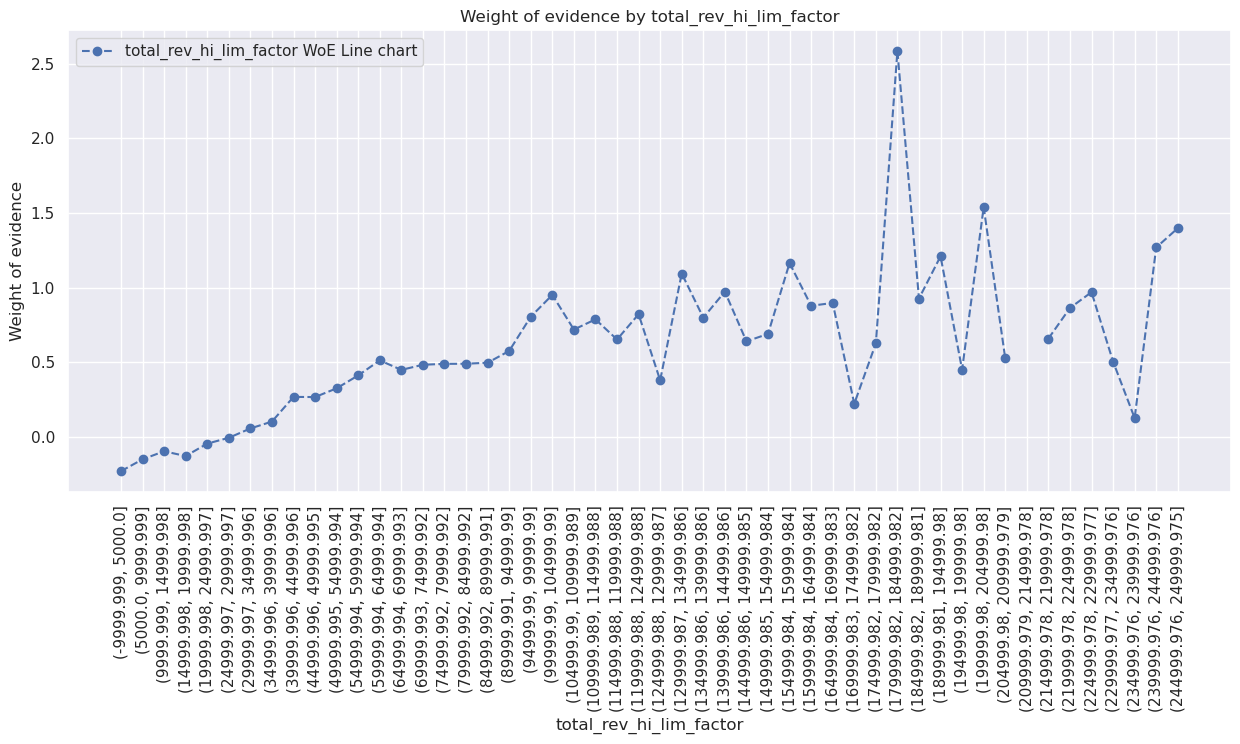

In [154]:
plot_woe(total_rev_woe.iloc[: 50, : ],90)

In [155]:
# '<=5K', '5K-10K', '10K-20K', '20K-30K', '30K-40K', '40K-55K', '55K-95K', '>95K'
x_train_prep['total_rev_hi_lim:<=5K'] = np.where((x_train_prep['total_rev_hi_lim'] <= 5000), 1, 0)
x_train_prep['total_rev_hi_lim:5K_10K'] = np.where((x_train_prep['total_rev_hi_lim'] > 5000) & (x_train_prep['total_rev_hi_lim'] <= 10000), 1, 0)
x_train_prep['total_rev_hi_lim:10K_20K'] = np.where((x_train_prep['total_rev_hi_lim'] > 10000) & (x_train_prep['total_rev_hi_lim'] <= 20000), 1, 0)
x_train_prep['total_rev_hi_lim:20K_30K'] = np.where((x_train_prep['total_rev_hi_lim'] > 20000) & (x_train_prep['total_rev_hi_lim'] <= 30000), 1, 0)
x_train_prep['total_rev_hi_lim:30K_40K'] = np.where((x_train_prep['total_rev_hi_lim'] > 30000) & (x_train_prep['total_rev_hi_lim'] <= 40000), 1, 0)
x_train_prep['total_rev_hi_lim:40K_55K'] = np.where((x_train_prep['total_rev_hi_lim'] > 40000) & (x_train_prep['total_rev_hi_lim'] <= 55000), 1, 0)
x_train_prep['total_rev_hi_lim:55K_95K'] = np.where((x_train_prep['total_rev_hi_lim'] > 55000) & (x_train_prep['total_rev_hi_lim'] <= 95000), 1, 0)
x_train_prep['total_rev_hi_lim:>95K'] = np.where((x_train_prep['total_rev_hi_lim'] > 95000), 1, 0)

/tmp/ipykernel_13001/467370893.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_train_prep['total_rev_hi_lim:10K_20K'] = np.where((x_train_prep['total_rev_hi_lim'] > 10000) & (x_train_prep['total_rev_hi_lim'] <= 20000), 1, 0)
/tmp/ipykernel_13001/467370893.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_train_prep['total_rev_hi_lim:20K_30K'] = np.where((x_train_prep['total_rev_hi_lim'] > 20000) & (x_train_prep['total_rev_hi_lim'] <= 30000), 1, 0)
/tmp/ipykernel_13001/467370893.py:6: PerformanceWarning: DataFrame is hi

In [156]:
if input_data == "train":
    list_of_dummy_variables.extend(["total_rev_hi_lim:<=5K", "total_rev_hi_lim:5K_10K", "total_rev_hi_lim:10K_20K", "total_rev_hi_lim:20K_30K", 
                                    "total_rev_hi_lim:30K_40K", "total_rev_hi_lim:40K_55K", "total_rev_hi_lim:55K_95K", "total_rev_hi_lim:>95K"])
    list_of_ref_categories.append("total_rev_hi_lim:<=5K")

In [157]:
list_of_ref_categories

['grade:G',
 'home_ownership:RENT_OTHER_NONE_ANY',
 'addr_state:NE_IA_NV_AL_ID_ND_FL_HI',
 'verification_status:Verified',
 'purpose:educ_small_biz_wedd_renno_enerby_moving_other_house',
 'initial_list_status:f',
 'term:60',
 'emp_length:0',
 'months_since_issued_date:>172',
 'int_rate:>20.281',
 'annual_inc:<20K',
 'mths_since_last_delinq:0_3',
 'months_since_earliest_cr_line:<171',
 'delinq_2yrs:>7',
 'inq_last_6mths:>6',
 'open_acc:<4',
 'pub_rec:0_2',
 'total_acc:<=28',
 'acc_now_delinq:0',
 'dti:>32',
 'mths_since_last_record:0_2',
 'total_rev_hi_lim:<=5K']

In [158]:
dataset = pd.concat([x_train_prep, y_train_prep], axis=1)
dataset.to_csv(f"./data/processed_{input_data}.csv", index=False)


if input_data == "train":
    cat_varibels = pd.DataFrame({"woe_vars": list_of_dummy_variables})
    ref_vars = pd.DataFrame({"ref_vars": list_of_ref_categories})
    cat_varibels.to_csv(f"./data/woe_cat_vars.csv", index=False)
    ref_vars.to_csv(f"./data/woe_ref_vars.csv", index=False)
    

In [159]:
del data, x_train, x_train_prep, y_train, y_train_prep, x_test, y_test